# Study beam impact point as a function of beam position


In [1]:
%load_ext autoreload
%autoreload 


In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import batoid
from scipy import stats

from ghosts import tools
from ghosts import plotter
from ghosts import simulator
from ghosts import tweak_optics
from ghosts import beam
from ghosts import geom
from ghosts import reflectivity

from ghosts.analysis import compute_ghost_separations, reduce_ghosts
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_3
from ghosts.geom_configs import GEOM_CONFIG_0

from ghosts.camera import build_camera, show_camera

plt.rcParams['font.size']=16

In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 9000 pixels per mm^2


Direct path is number 20
  central impact point is (0.069893, 0.214366)
  transmission is 0.7231

Maximum expected flux is 0.7231
Maximum bin content is 718.1936


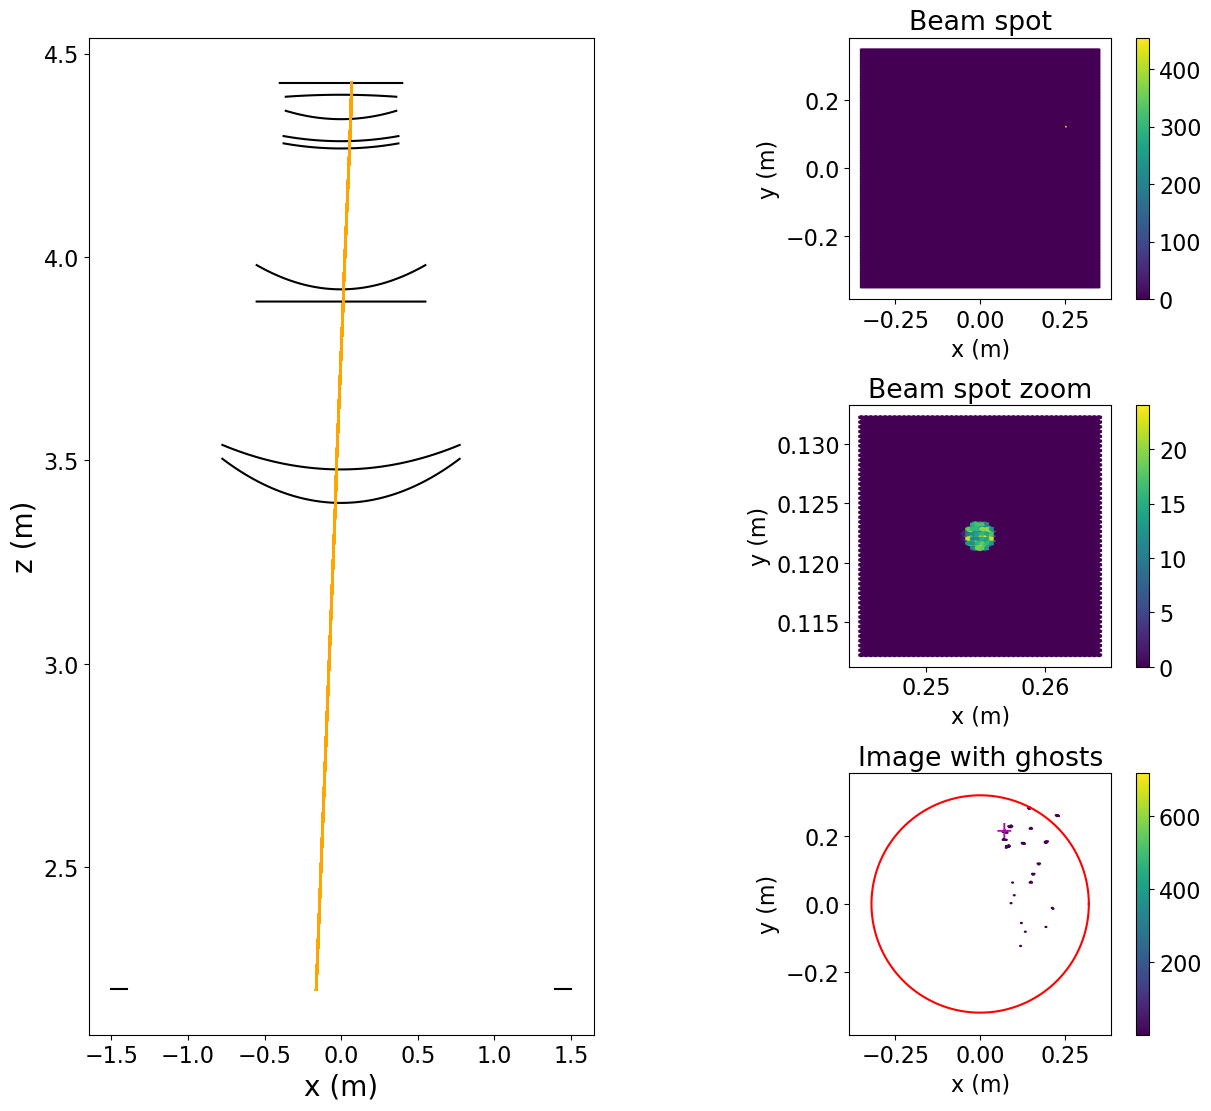

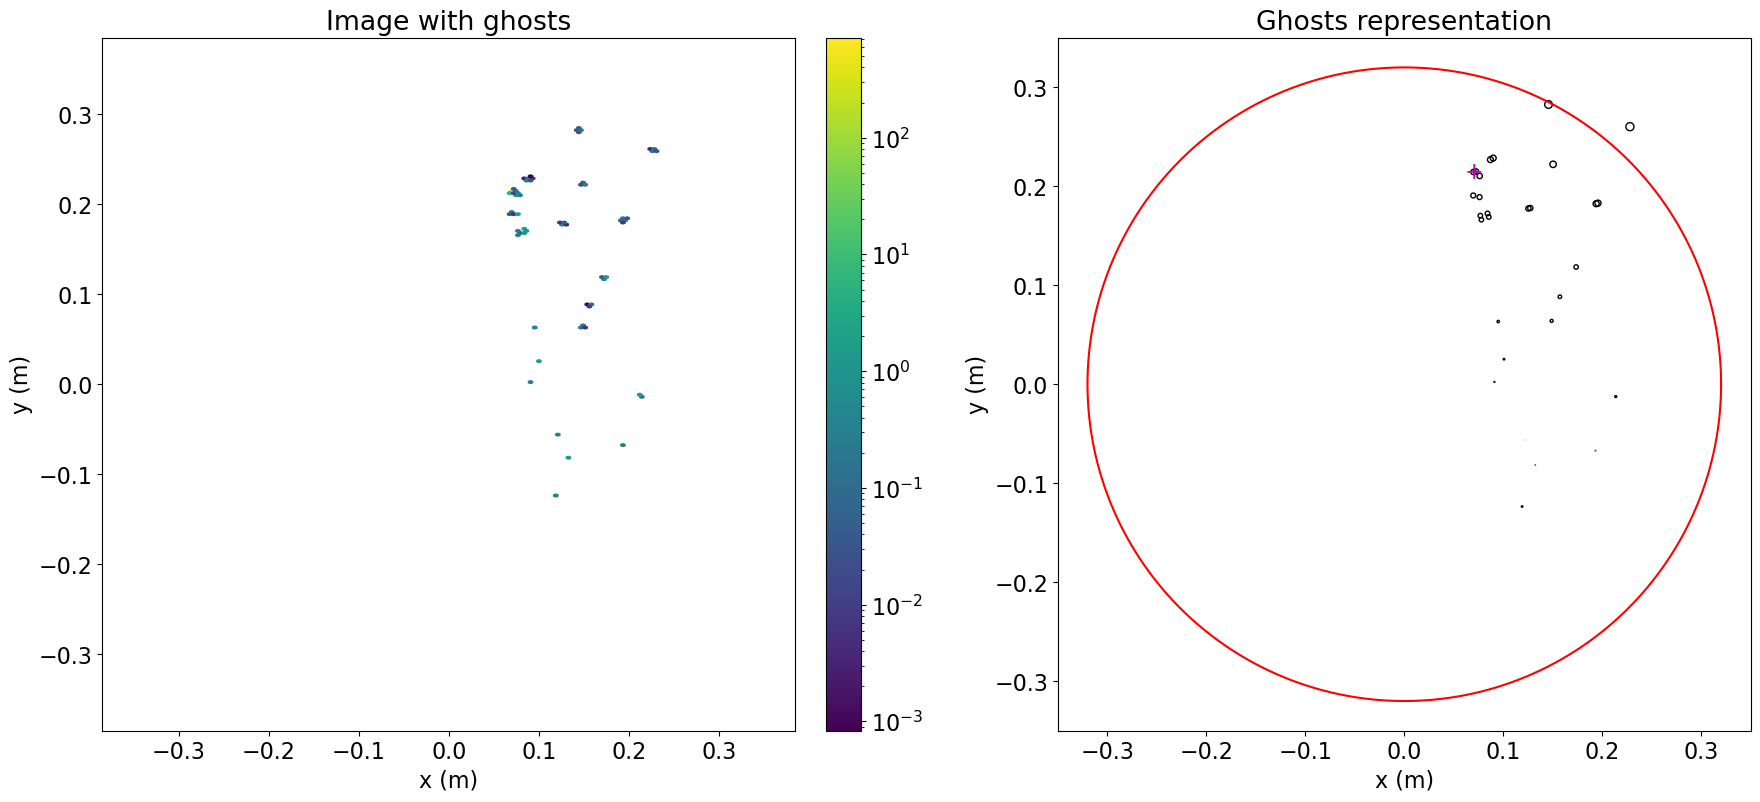

In [4]:
# Second CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_with_filter.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope
tweak_optics.make_optics_reflective(telescope, coating='smart', r_frac=[0.02, 0.02, 0.15])

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_3)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

# camera and ghosts visualization
spots_data, _spots = reduce_ghosts(r_forward)
data_frame = make_data_frame(spots_data)
_fig, _ax = plotter.plot_full_camera_and_spots(r_forward, data_frame, log_scale=True)

## First work on a square beam set on the first quadrant

In [5]:
x_scan = list(np.arange(0, 0.26, 0.02))
y_scan = list(np.arange(0, 0.26, 0.02))
x_scan, y_scan

([0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24],
 [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24])

In [6]:
beam_scan = beam.build_translation_set(BEAM_CONFIG_0, 'x', x_scan, base_id=0)
[(b['x_offset'], b['y_offset']) for b in beam_scan]

[(0.0, 0),
 (0.02, 0),
 (0.04, 0),
 (0.06, 0),
 (0.08, 0),
 (0.1, 0),
 (0.12, 0),
 (0.14, 0),
 (0.16, 0),
 (0.18, 0),
 (0.2, 0),
 (0.22, 0),
 (0.24, 0)]

In [7]:
beams_set = list()
start_config = copy.deepcopy(BEAM_CONFIG_0)
start_config['n_photons'] = 100

beam_scan_0 = beam.build_translation_set(start_config, 'x', x_scan, base_id=0)
beams_set.extend(beam_scan_0)
bid = len(beams_set)-1
for b in beam_scan_0:
    ts = beam.build_translation_set(b, 'y', y_scan, base_id=bid)
    beams_set.extend(ts[1:])
    bid = bid+len(ts)-1



In [8]:
beam_df = beam.concat_dicts(beams_set)
beam_df[10:15]


,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler
10,10,5.000000e-07,100,0.00125,0.20,0.00,2.797473,0.0,0.0,0.0
11,11,5.000000e-07,100,0.00125,0.22,0.00,2.797473,0.0,0.0,0.0
12,12,5.000000e-07,100,0.00125,0.24,0.00,2.797473,0.0,0.0,0.0
13,13,5.000000e-07,100,0.00125,0.00,0.02,2.797473,0.0,0.0,0.0
14,14,5.000000e-07,100,0.00125,0.00,0.04,2.797473,0.0,0.0,0.0


In [9]:
# get impact points for each beam config
impact_x = list()
impact_y = list()
impact_id = list()
for one_beam in beams_set:
    print('Simulating beam id ', one_beam['beam_id'], end='\r')
    _trace_full, forward_rays, _reverse_rays, _rays = simulator.run_simulation(telescope, one_beam)
    _n, x, y, _f = tools.get_main_impact_point(forward_rays)
    impact_x.append(x)
    impact_y.append(y)
    impact_id.append(one_beam['beam_id'])
    

In [10]:
impact_df = pd.DataFrame({'beam_id': impact_id, 'x_spot': impact_x, 'y_spot': impact_y})
impact_df.head()

,beam_id,x_spot,y_spot
0,0,0.000735,0.000495
1,1,0.020471,0.000361
2,2,0.040419,0.000365
3,3,0.060339,0.000360
4,4,0.080137,0.000367


In [11]:
# join
df = beam_df.join(impact_df.set_index('beam_id'), on='beam_id')
df.head()

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler,x_spot,y_spot
0,0,5.000000e-07,100,0.00125,0.00,0.0,2.797473,0.0,0.0,0.0,0.000735,0.000495
1,1,5.000000e-07,100,0.00125,0.02,0.0,2.797473,0.0,0.0,0.0,0.020471,0.000361
2,2,5.000000e-07,100,0.00125,0.04,0.0,2.797473,0.0,0.0,0.0,0.040419,0.000365
3,3,5.000000e-07,100,0.00125,0.06,0.0,2.797473,0.0,0.0,0.0,0.060339,0.000360
4,4,5.000000e-07,100,0.00125,0.08,0.0,2.797473,0.0,0.0,0.0,0.080137,0.000367


In [12]:
# compute more stuff
df['beam_dist_to_center'] = np.sqrt(df['x_offset']*df['x_offset']+df['y_offset']*df['y_offset'])
df['spot_dist_to_center'] = np.sqrt(df['x_spot']*df['x_spot']+df['y_spot']*df['y_spot'])
df['convergence'] = df['spot_dist_to_center']/df['beam_dist_to_center']
df.replace([np.inf, -np.inf], np.nan, inplace=True)

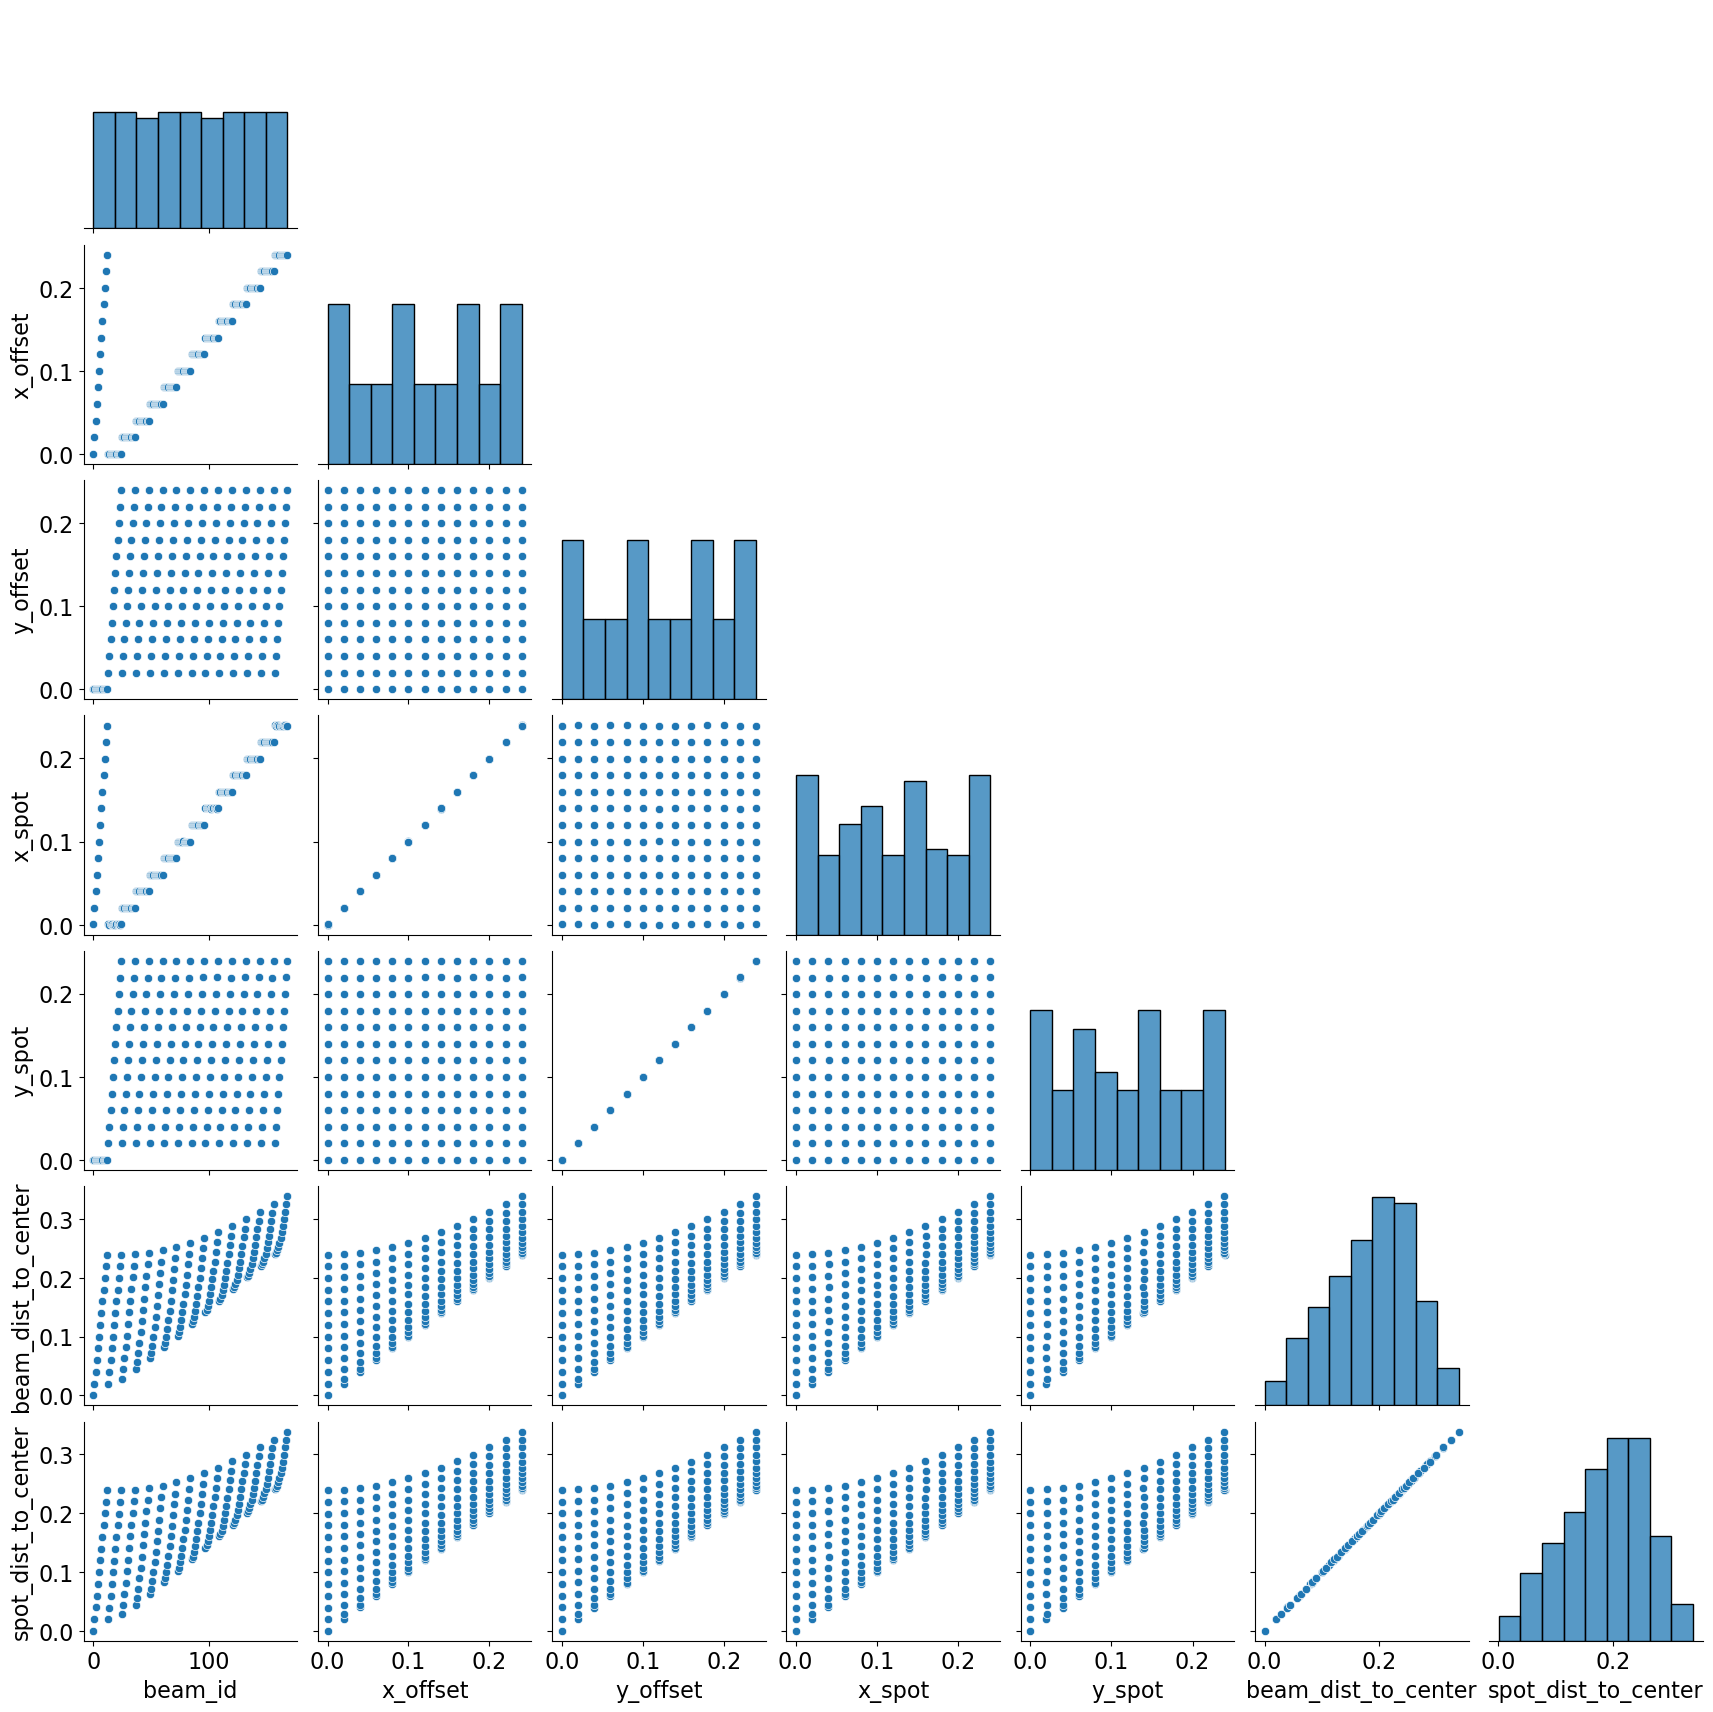

In [13]:
sns.pairplot(df, vars=['beam_id', 'x_offset', 'y_offset', 'x_spot', 'y_spot', 'beam_dist_to_center', 'spot_dist_to_center'], corner=True)

Direct path is number 28
  central impact point is (0.000678, 0.119864)
  transmission is 0.7231

Maximum expected flux is 0.7231
Maximum bin content is 37.7497


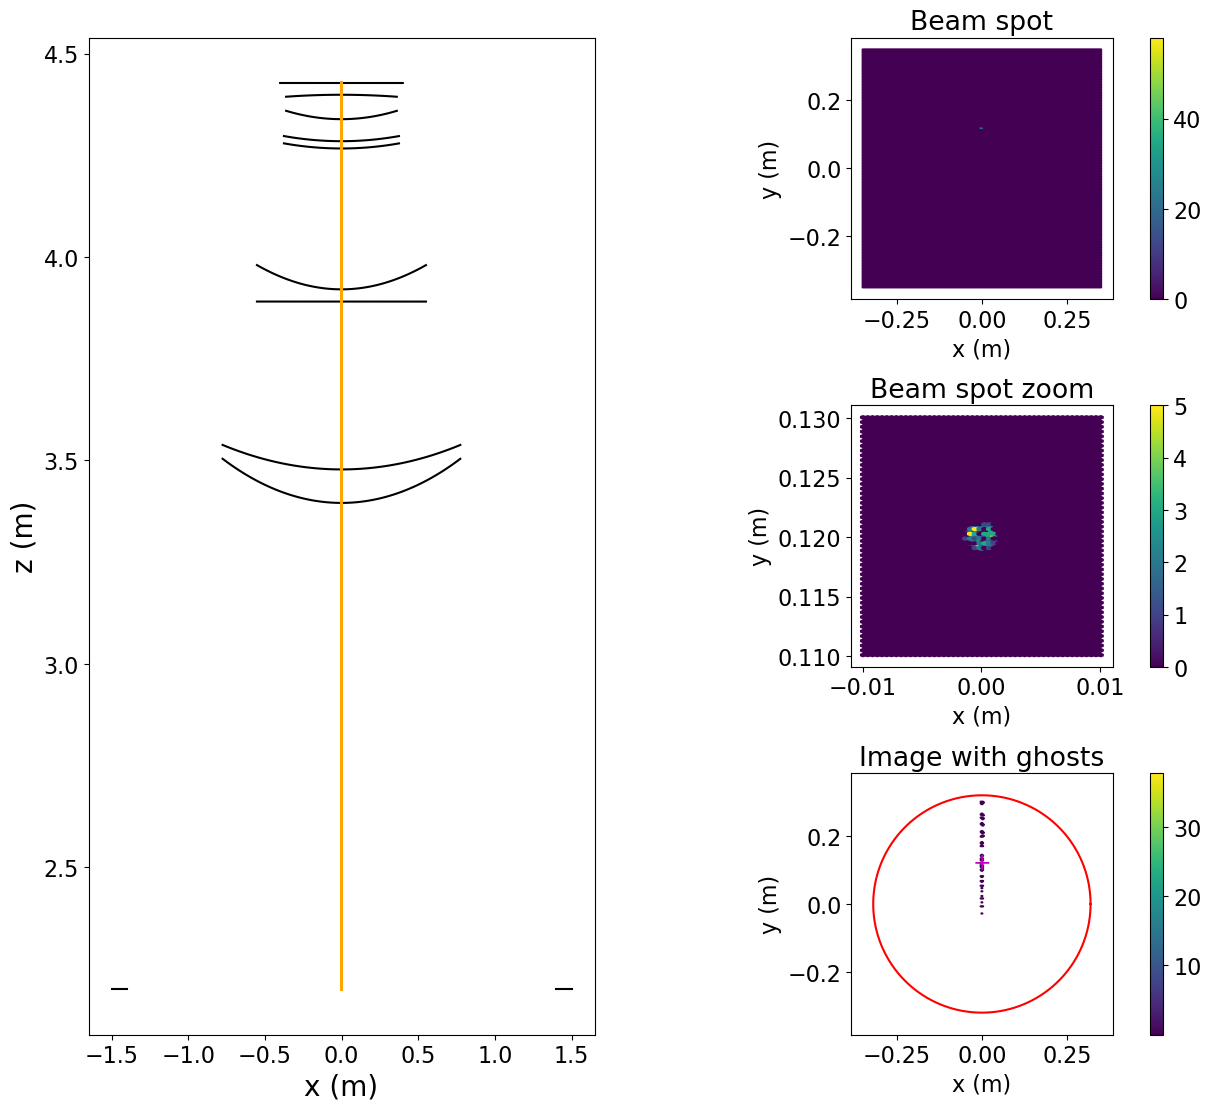

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler,x_spot,y_spot,beam_dist_to_center,spot_dist_to_center,convergence
18,18,5.000000e-07,100,0.00125,0.0,0.12,2.797473,0.0,0.0,0.0,0.000582,0.119845,0.12,0.119847,0.998724


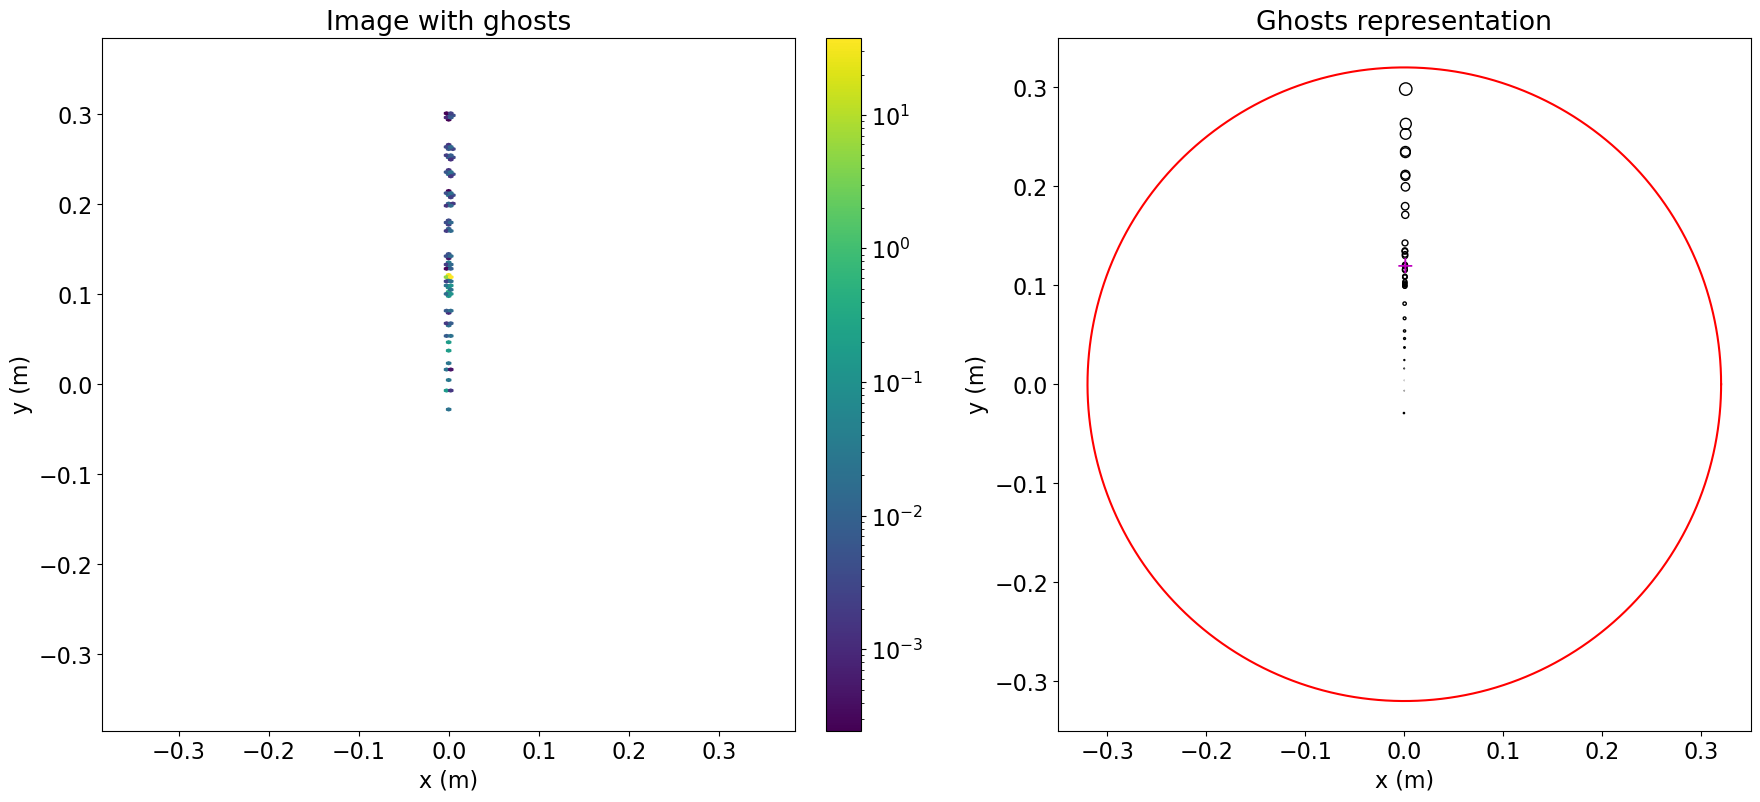

In [14]:
# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=beams_set[18])
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

# camera and ghosts visualization
spots_data, _spots = reduce_ghosts(r_forward)
data_frame = make_data_frame(spots_data)
_fig, _ax = plotter.plot_full_camera_and_spots(r_forward, data_frame, log_scale=True)

# results
df[df['beam_id'] == 18]

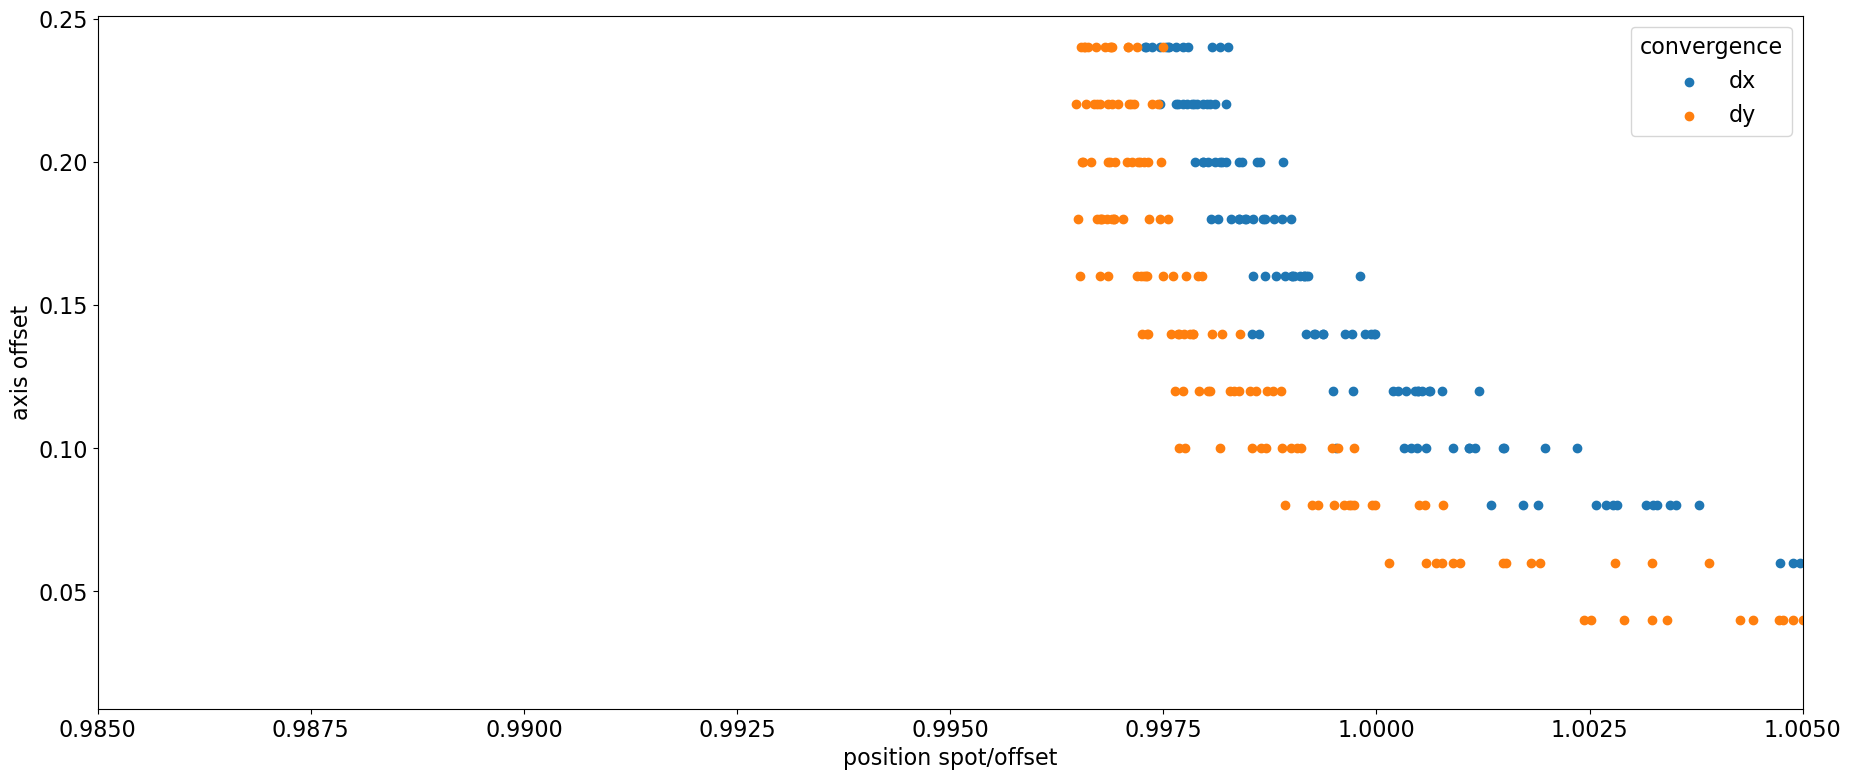

In [15]:
# Look at spot position vs beam position 
plt.scatter(df['x_spot']/df['x_offset'], df['x_offset'], label='dx')
plt.scatter(df['y_spot']/df['y_offset'], df['y_offset'], label='dy')
plt.xlabel('position spot/offset')
plt.ylabel('axis offset')
plt.xlim(0.985, 1.005)
plt.legend(title='convergence')

Text(0.5, 1.0, 'Displacement from beam offset to beam impact point on camera')

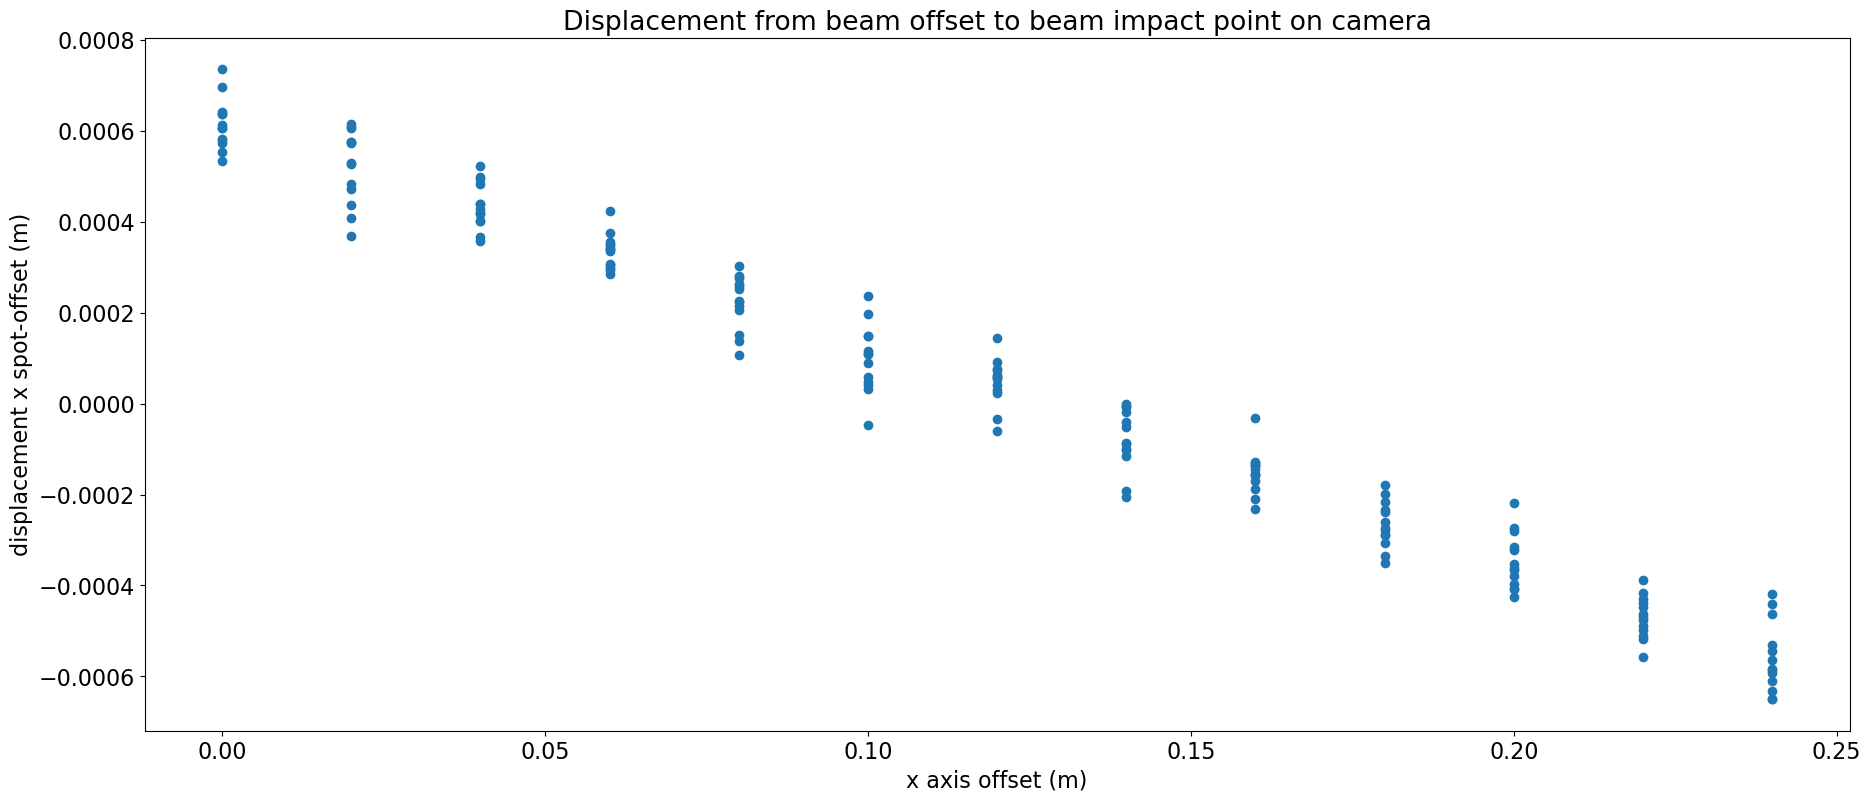

In [16]:
# quick look at real displacement from beam offset to beam impact point on camera
plt.scatter(df['x_offset'], df['x_spot']-df['x_offset'], label='displacement')
plt.xlabel('x axis offset (m)')
plt.ylabel('displacement x spot-offset (m)')
plt.title('Displacement from beam offset to beam impact point on camera')

Filter fit results: intercept = 0.000573, slope = -0.005


Text(0.15, -0.00025, 'Slope = 5 mm / m')

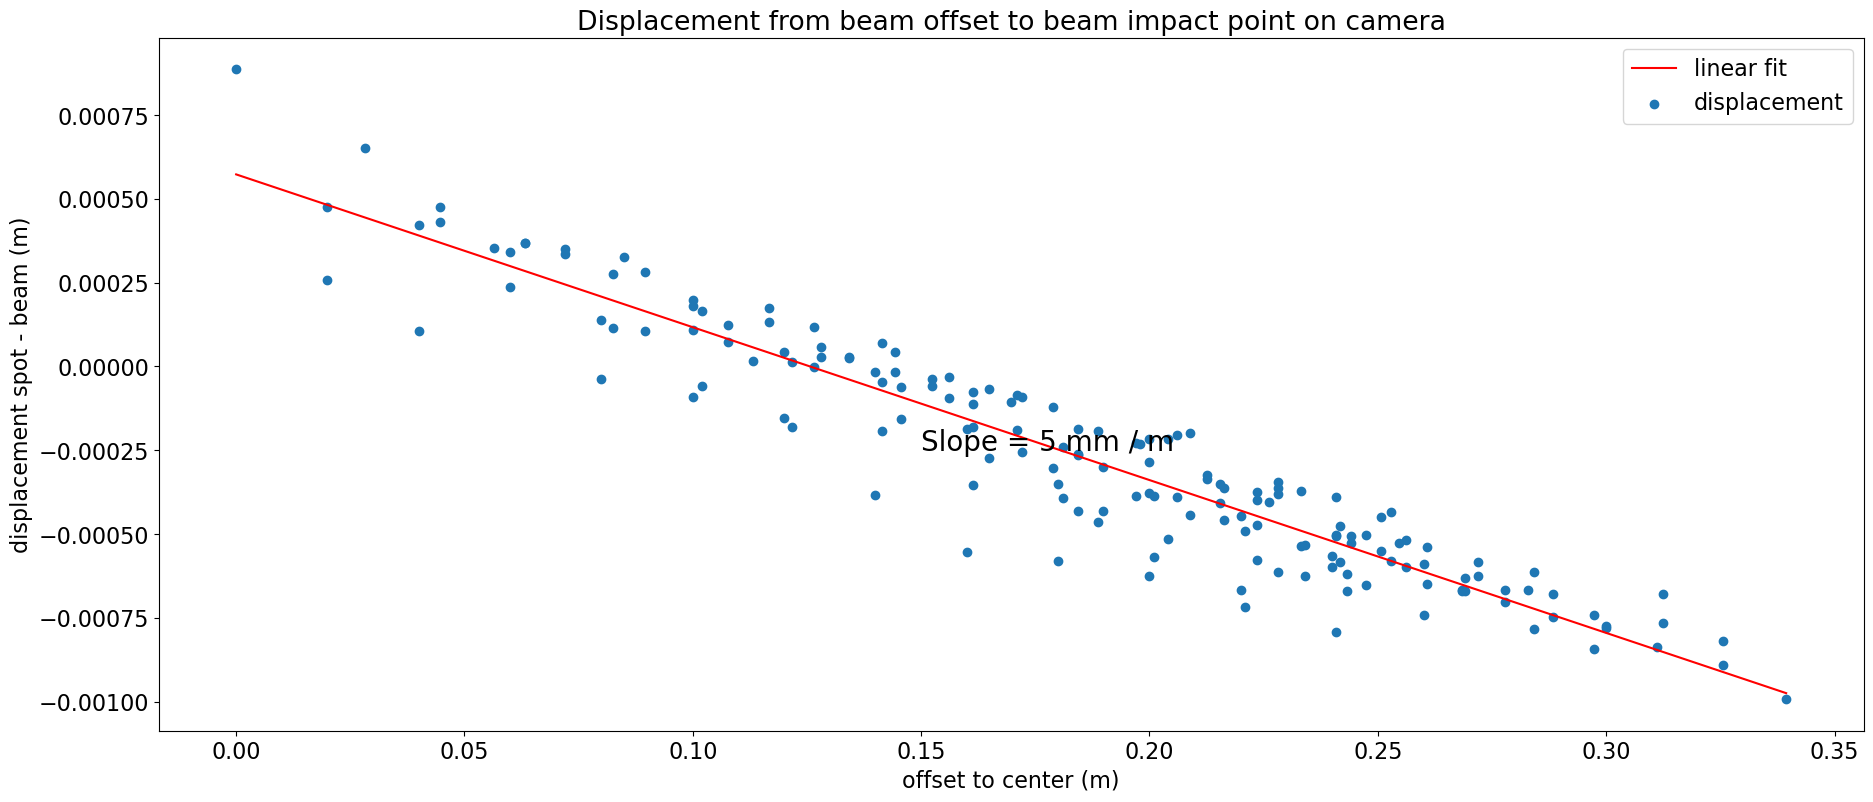

In [17]:
# quick look at real displacement from beam offset to beam impact point on camera
plt.scatter(df['beam_dist_to_center'], df['spot_dist_to_center']-df['beam_dist_to_center'], label='displacement')
plt.xlabel('offset to center (m)')
plt.ylabel('displacement spot - beam (m)')
plt.title('Displacement from beam offset to beam impact point on camera')

# Linear fit for x shift
x_lin_fit = stats.linregress(df['beam_dist_to_center'], df['spot_dist_to_center']-df['beam_dist_to_center'])
print(f'Filter fit results: intercept = {x_lin_fit.intercept:.6f}, slope = {x_lin_fit.slope:.3f}')
x_interp_ys = [x_lin_fit.intercept + x_lin_fit.slope * x for x in df['beam_dist_to_center']]
plt.plot(df['beam_dist_to_center'], x_interp_ys, 'r', label='linear fit')
plt.legend()

# write text
plt.text(0.15, -0.00025, f'Slope = 5 mm / m', fontsize=20)

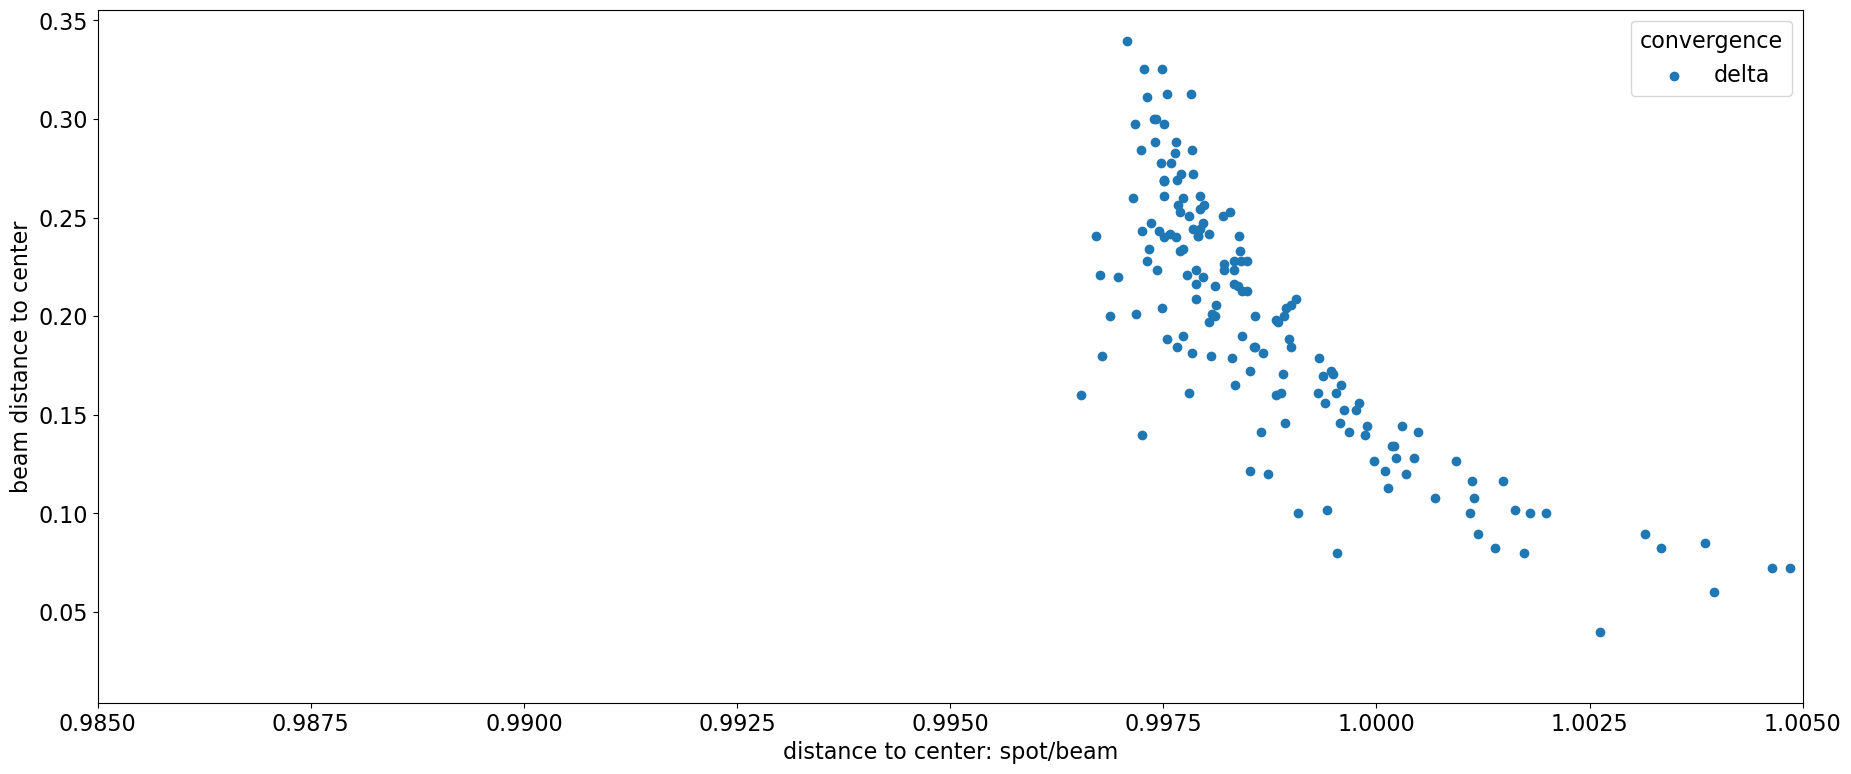

In [18]:
plt.scatter(df['spot_dist_to_center']/df['beam_dist_to_center'], df['beam_dist_to_center'], label='delta')
plt.xlabel('distance to center: spot/beam')
plt.ylabel('beam distance to center')
plt.xlim(0.985, 1.005)
plt.legend(title='convergence')

In [19]:
# gaussian fit to convergence
(x_mu, x_sigma) = stats.norm.fit(df['convergence'].dropna())


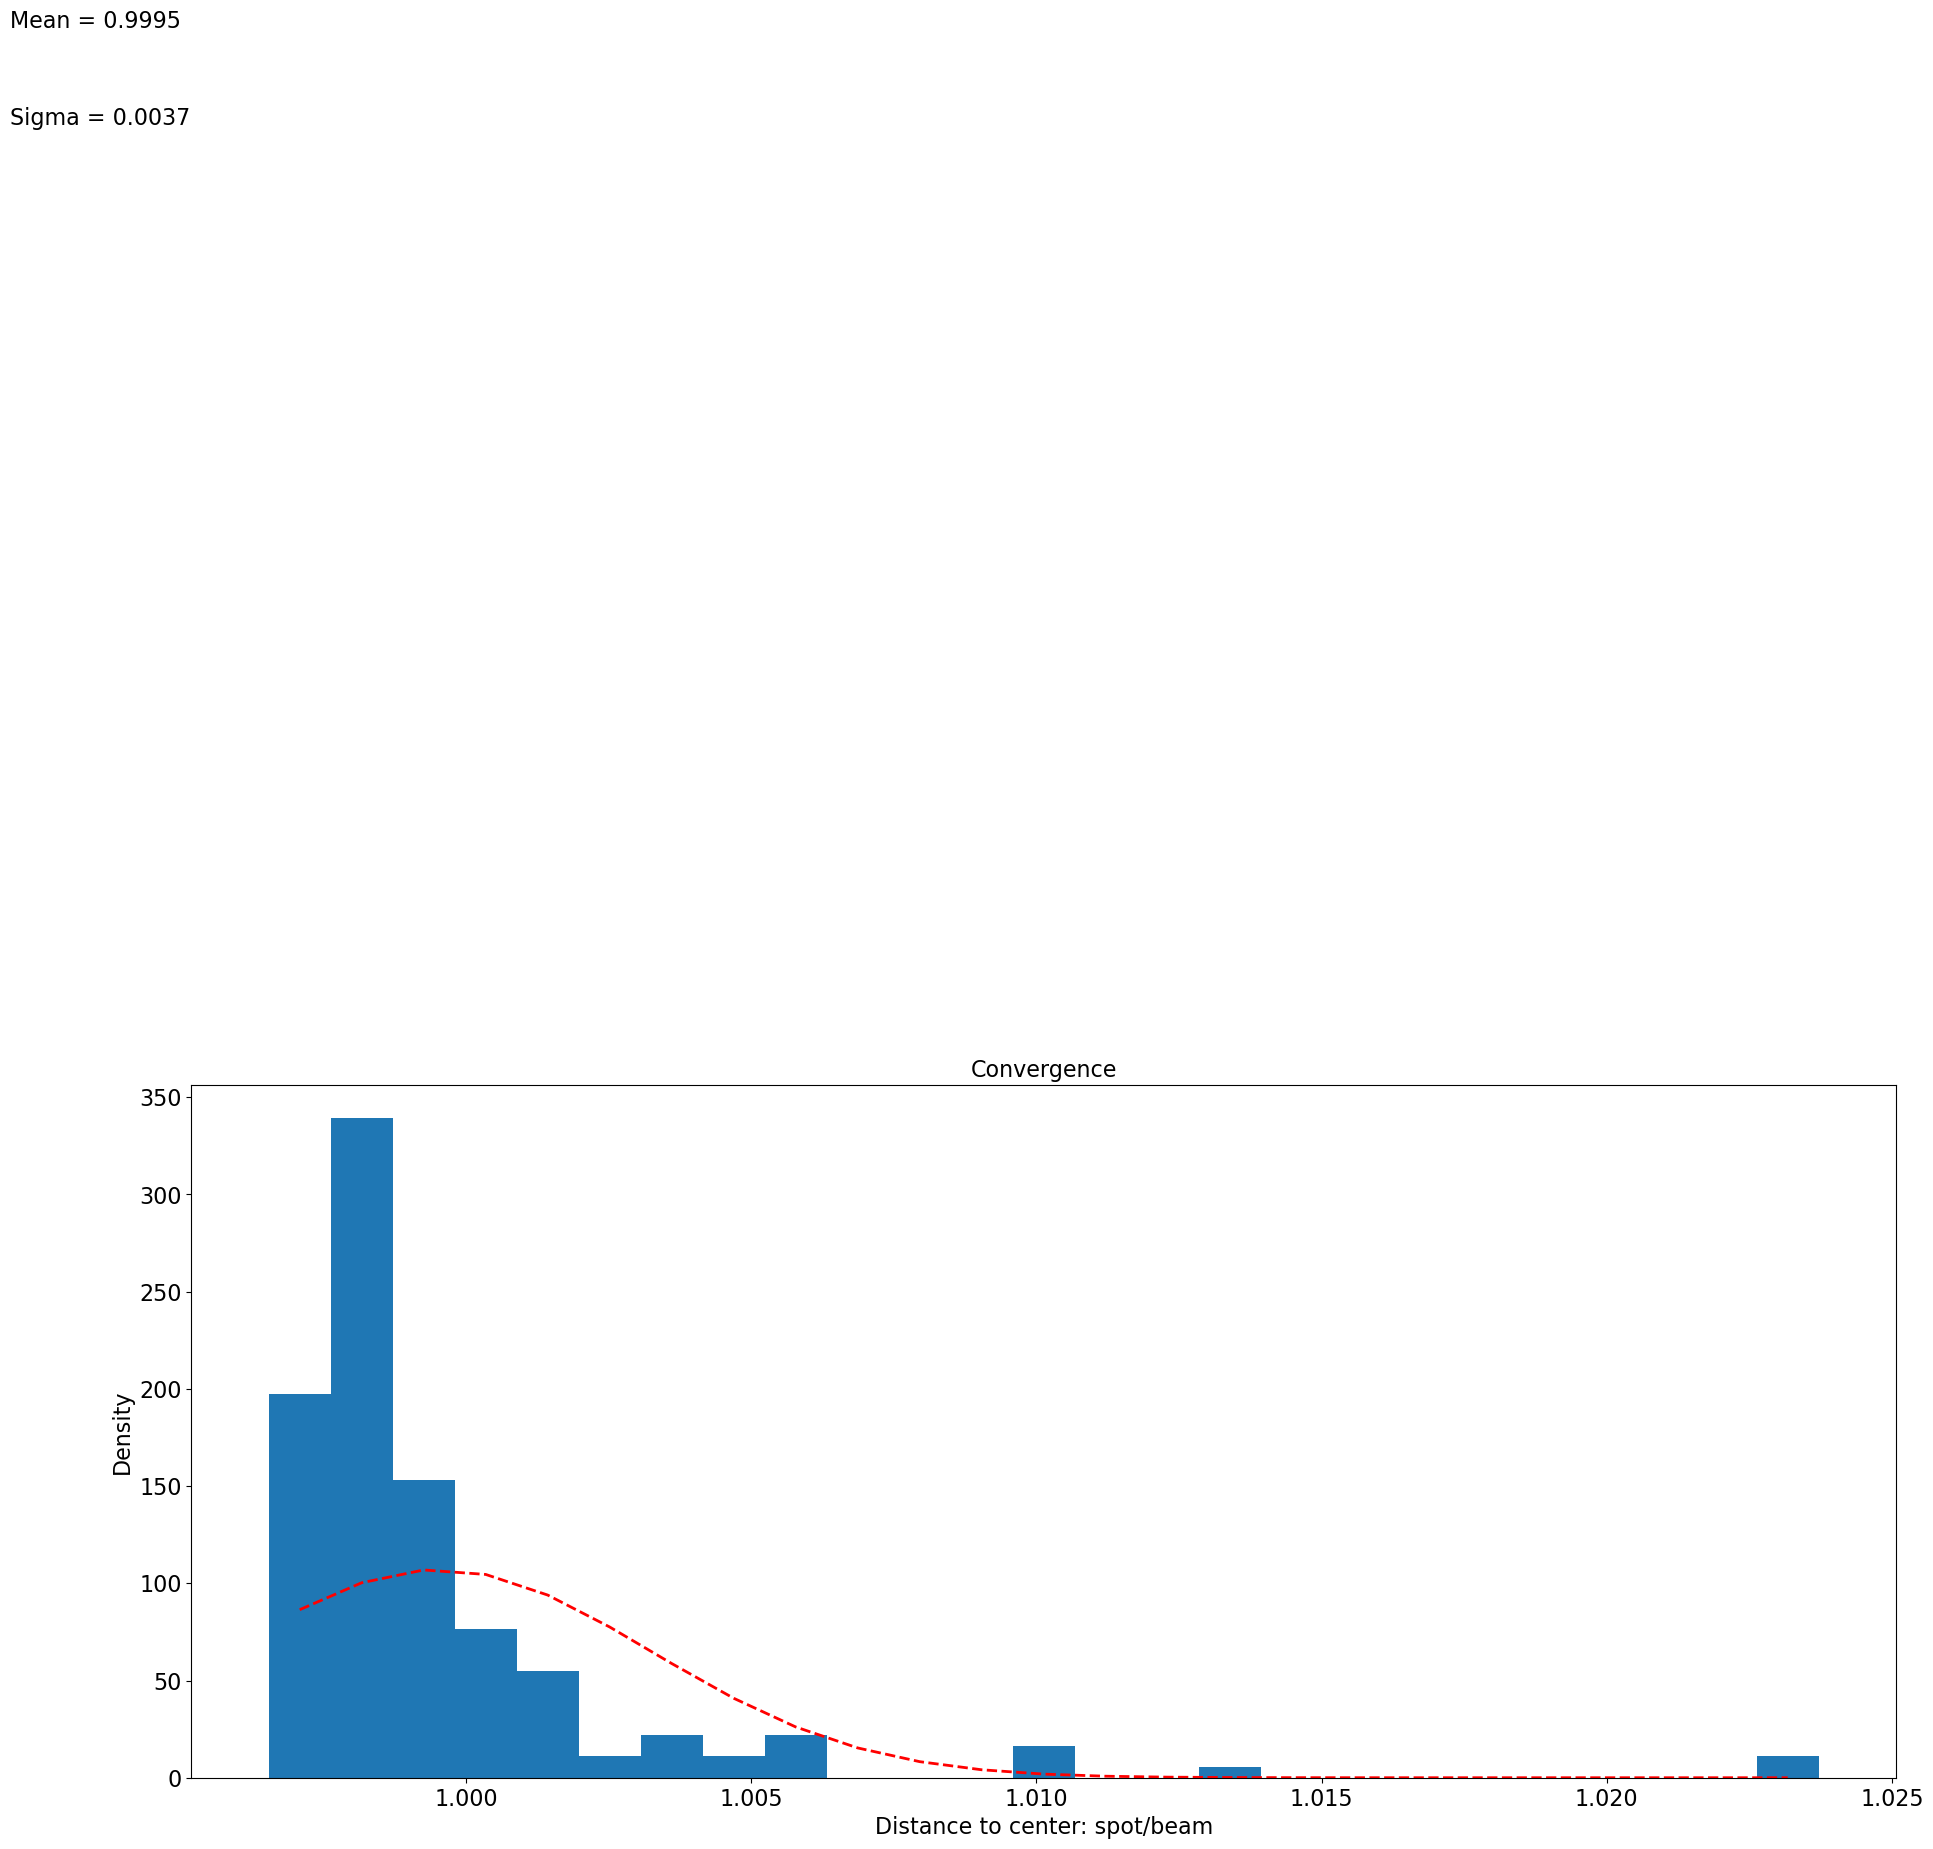

In [20]:
# plot convergence histogram
x_n, x_bins, x_patches = plt.hist(df['convergence'], bins=25, density=True)
plt.xlabel('Distance to center: spot/beam', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Convergence', fontsize=16)

# write text
plt.text(0.992, 900, f'Mean = {x_mu:.4f}', fontsize=16)
plt.text(0.992, 850, f'Sigma = {x_sigma:.4f}', fontsize=16)

# plot gaussian fit
x_bin_centers = 0.5 * (x_bins[1:] + x_bins[:-1])
x_y = stats.norm.pdf(x_bin_centers, x_mu, x_sigma)
plt.plot(x_bin_centers, x_y, 'r--', linewidth=2)


## Now work on polar beam set

In [21]:
hex_beams = list()
base_id = 0

distances = np.arange(0.0, 0.36, 0.02)
thetas = np.arange(0, 105, 15)

start_config = copy.deepcopy(BEAM_CONFIG_0)
start_config['n_photons'] = 100

hex_beams.extend([start_config])
i = 1
for dist in distances[1:]:
    for theta in thetas:
        beam_config = copy.deepcopy(start_config)
        beam_config['beam_id'] = i
        beam_config['x_offset'] = dist*math.cos(math.radians(theta))
        beam_config['y_offset'] = dist*math.sin(math.radians(theta))
        hex_beams.append(beam_config)
        i = i+1


In [22]:
hex_beams

[{'beam_id': 0,
  'wl': 5e-07,
  'n_photons': 100,
  'radius': 0.00125,
  'x_offset': 0.0,
  'y_offset': 0,
  'z_offset': 2.7974726,
  'z_euler': 0.0,
  'y_euler': 0.0,
  'x_euler': 0.0},
 {'beam_id': 1,
  'wl': 5e-07,
  'n_photons': 100,
  'radius': 0.00125,
  'x_offset': 0.02,
  'y_offset': 0.0,
  'z_offset': 2.7974726,
  'z_euler': 0.0,
  'y_euler': 0.0,
  'x_euler': 0.0},
 {'beam_id': 2,
  'wl': 5e-07,
  'n_photons': 100,
  'radius': 0.00125,
  'x_offset': 0.019318516525781367,
  'y_offset': 0.005176380902050415,
  'z_offset': 2.7974726,
  'z_euler': 0.0,
  'y_euler': 0.0,
  'x_euler': 0.0},
 {'beam_id': 3,
  'wl': 5e-07,
  'n_photons': 100,
  'radius': 0.00125,
  'x_offset': 0.017320508075688773,
  'y_offset': 0.009999999999999998,
  'z_offset': 2.7974726,
  'z_euler': 0.0,
  'y_euler': 0.0,
  'x_euler': 0.0},
 {'beam_id': 4,
  'wl': 5e-07,
  'n_photons': 100,
  'radius': 0.00125,
  'x_offset': 0.014142135623730952,
  'y_offset': 0.014142135623730949,
  'z_offset': 2.7974726,
  'z

In [23]:
hex_beam_df = beam.concat_dicts(hex_beams)
hex_beam_df


,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler
0,0,5.000000e-07,100,0.00125,0.000000e+00,0.000000,2.797473,0.0,0.0,0.0
1,1,5.000000e-07,100,0.00125,2.000000e-02,0.000000,2.797473,0.0,0.0,0.0
2,2,5.000000e-07,100,0.00125,1.931852e-02,0.005176,2.797473,0.0,0.0,0.0
3,3,5.000000e-07,100,0.00125,1.732051e-02,0.010000,2.797473,0.0,0.0,0.0
4,4,5.000000e-07,100,0.00125,1.414214e-02,0.014142,2.797473,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
115,115,5.000000e-07,100,0.00125,2.944486e-01,0.170000,2.797473,0.0,0.0,0.0
116,116,5.000000e-07,100,0.00125,2.404163e-01,0.240416,2.797473,0.0,0.0,0.0
117,117,5.000000e-07,100,0.00125,1.700000e-01,0.294449,2.797473,0.0,0.0,0.0
118,118,5.000000e-07,100,0.00125,8.799848e-02,0.328415,2.797473,0.0,0.0,0.0


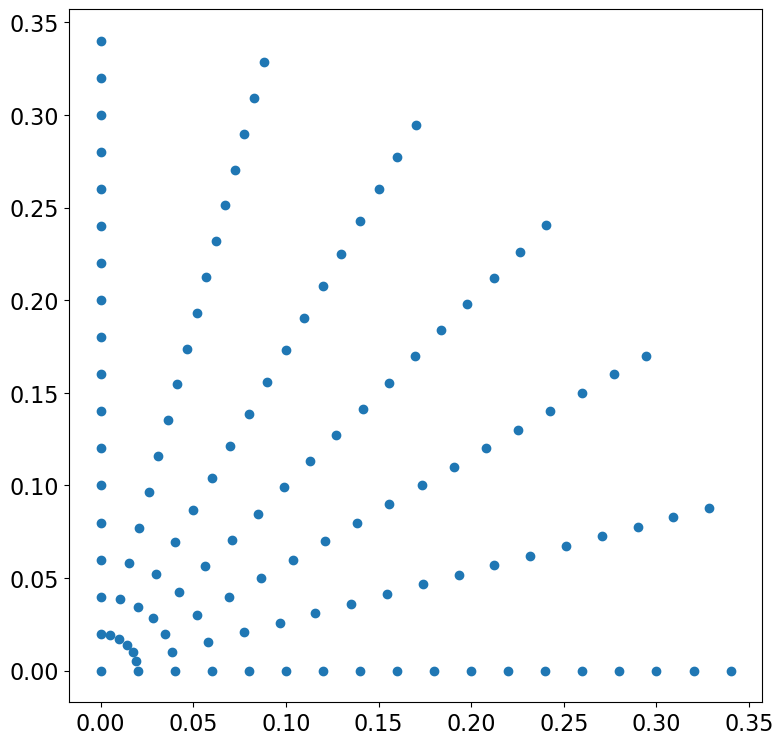

In [24]:
plt.scatter(hex_beam_df['x_offset'], hex_beam_df['y_offset'])
plt.gca().set_aspect('equal')

In [25]:
# get impact points for each beam config
hex_impact_x = list()
hex_impact_y = list()
hex_impact_id = list()
for one_beam in hex_beams:
    print('Simulating beam id ', one_beam['beam_id'], end='\r')
    _trace_full, forward_rays, _reverse_rays, _rays = simulator.run_simulation(telescope, one_beam)
    _n, x, y, _f = tools.get_main_impact_point(forward_rays)
    hex_impact_x.append(x)
    hex_impact_y.append(y)
    hex_impact_id.append(one_beam['beam_id'])
    

In [26]:
hex_impact_df = pd.DataFrame({'beam_id': hex_impact_id, 'x_spot': hex_impact_x, 'y_spot': hex_impact_y})
hex_impact_df.head()

,beam_id,x_spot,y_spot
0,0,0.000629,0.000327
1,1,0.020554,0.000450
2,2,0.019892,0.005549
3,3,0.017828,0.010410
4,4,0.014711,0.014463


In [27]:
# join
hex_df = hex_beam_df.join(hex_impact_df.set_index('beam_id'), on='beam_id')
hex_df.head()

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler,x_spot,y_spot
0,0,5.000000e-07,100,0.00125,0.000000,0.000000,2.797473,0.0,0.0,0.0,0.000629,0.000327
1,1,5.000000e-07,100,0.00125,0.020000,0.000000,2.797473,0.0,0.0,0.0,0.020554,0.000450
2,2,5.000000e-07,100,0.00125,0.019319,0.005176,2.797473,0.0,0.0,0.0,0.019892,0.005549
3,3,5.000000e-07,100,0.00125,0.017321,0.010000,2.797473,0.0,0.0,0.0,0.017828,0.010410
4,4,5.000000e-07,100,0.00125,0.014142,0.014142,2.797473,0.0,0.0,0.0,0.014711,0.014463


In [28]:
# compute more stuff
hex_df['beam_dist_to_center'] = np.sqrt(hex_df['x_offset']*hex_df['x_offset']+hex_df['y_offset']*hex_df['y_offset'])
hex_df['spot_dist_to_center'] = np.sqrt(hex_df['x_spot']*hex_df['x_spot']+hex_df['y_spot']*hex_df['y_spot'])
hex_df['convergence'] = hex_df['spot_dist_to_center']/hex_df['beam_dist_to_center']
hex_df.replace([np.inf, -np.inf], np.nan, inplace=True)
hex_df.head()

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler,x_spot,y_spot,beam_dist_to_center,spot_dist_to_center,convergence
0,0,5.000000e-07,100,0.00125,0.000000,0.000000,2.797473,0.0,0.0,0.0,0.000629,0.000327,0.00,0.000709,NaN
1,1,5.000000e-07,100,0.00125,0.020000,0.000000,2.797473,0.0,0.0,0.0,0.020554,0.000450,0.02,0.020559,1.027968
2,2,5.000000e-07,100,0.00125,0.019319,0.005176,2.797473,0.0,0.0,0.0,0.019892,0.005549,0.02,0.020652,1.032595
3,3,5.000000e-07,100,0.00125,0.017321,0.010000,2.797473,0.0,0.0,0.0,0.017828,0.010410,0.02,0.020645,1.032243
4,4,5.000000e-07,100,0.00125,0.014142,0.014142,2.797473,0.0,0.0,0.0,0.014711,0.014463,0.02,0.020630,1.031494


Filter fit results: intercept = 0.000622, slope = -0.005


Text(0.15, -0.00025, 'Slope = 5 mm / m')

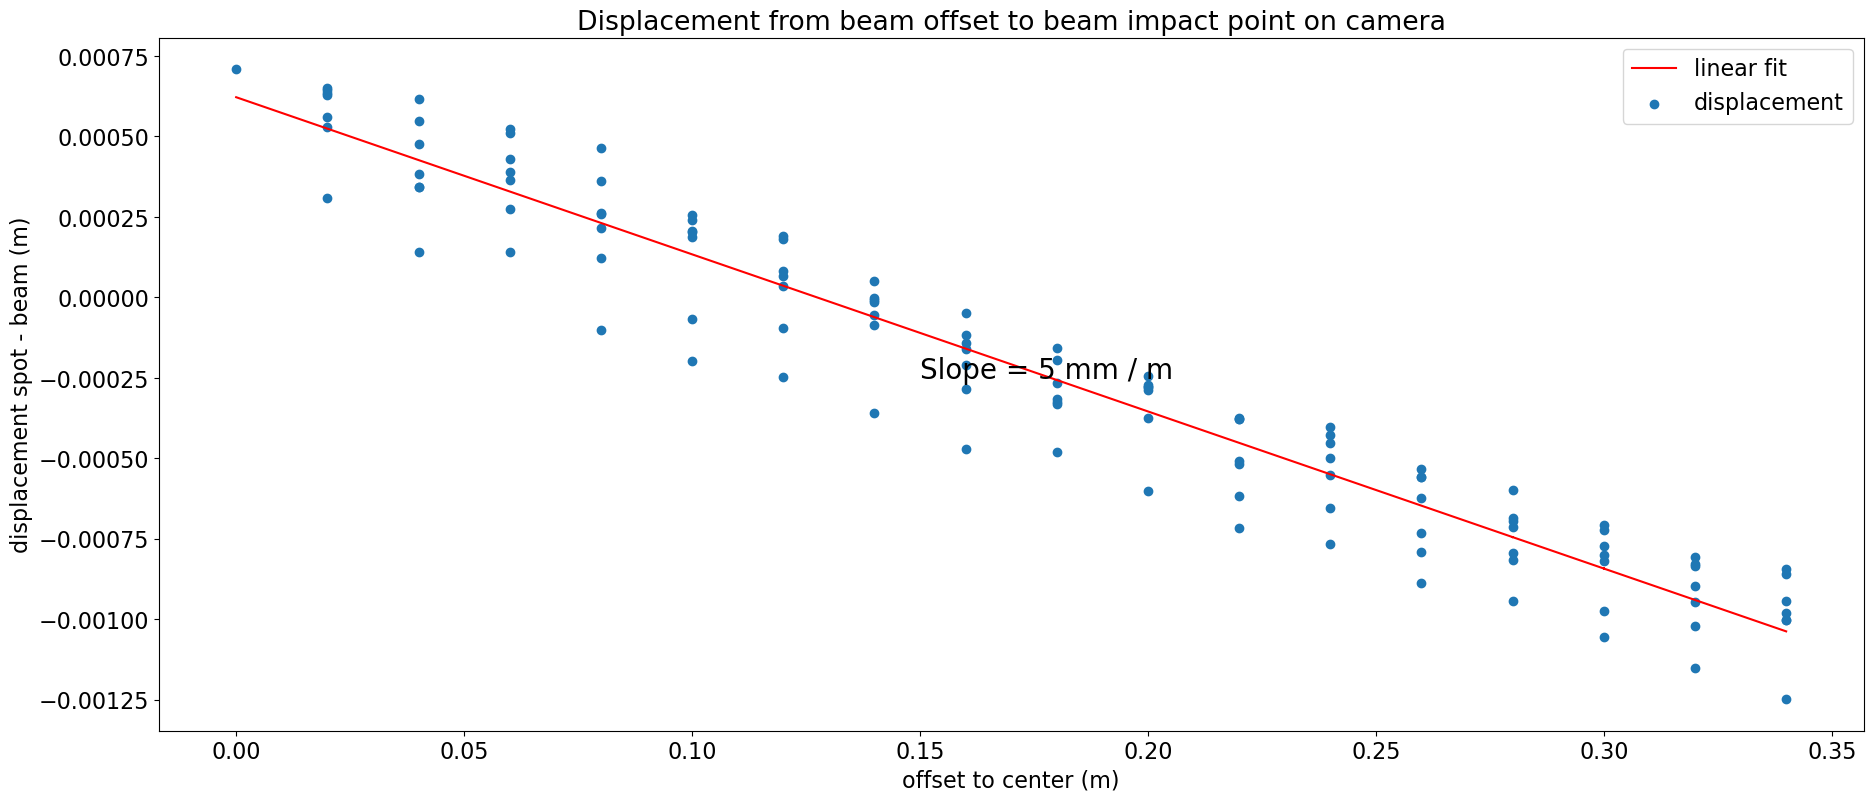

In [29]:
# quick look at real displacement from beam offset to beam impact point on camera
plt.scatter(hex_df['beam_dist_to_center'], hex_df['spot_dist_to_center']-hex_df['beam_dist_to_center'], label='displacement')
plt.xlabel('offset to center (m)')
plt.ylabel('displacement spot - beam (m)')
plt.title('Displacement from beam offset to beam impact point on camera')

# Linear fit for x shift
x_lin_fit = stats.linregress(hex_df['beam_dist_to_center'], hex_df['spot_dist_to_center']-hex_df['beam_dist_to_center'])
print(f'Filter fit results: intercept = {x_lin_fit.intercept:.6f}, slope = {x_lin_fit.slope:.3f}')
x_interp_ys = [x_lin_fit.intercept + x_lin_fit.slope * x for x in hex_df['beam_dist_to_center']]
plt.plot(hex_df['beam_dist_to_center'], x_interp_ys, 'r', label='linear fit')
plt.legend()

# write text
plt.text(0.15, -0.00025, f'Slope = 5 mm / m', fontsize=20)

## Now check what happens with a randomized telescope

In [30]:
# show off functions
# build a set of polar beams
polar_set = beam.build_first_quadrant_polar_set()
# create a randomized telescope
rnd_tel = tweak_optics.randomized_telescope(telescope)
tweak_optics.make_optics_reflective(rnd_tel)
# run simulations to get impact points
full_df = simulator.simulate_impact_points_for_beam_set(rnd_tel, polar_set)


Filter fit results: intercept = 0.000902, slope = -0.005


(<Figure size 1800x2400 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'beam'}, xlabel='x_offset (m)', ylabel='y_offset (m)'>,
         <AxesSubplot:title={'center':'impact point'}, xlabel='x_spot (m)', ylabel='y_spot (m)'>],
        [<AxesSubplot:title={'center':'beam vs impact point in x'}, xlabel='x_offset (m)', ylabel='x_spot (m)'>,
         <AxesSubplot:title={'center':'beam vs impact point in y'}, xlabel='y_offset (m)', ylabel='y_spot (m)'>],
        [<AxesSubplot:title={'center':'distance to center'}, xlabel='beam distance to center (m)', ylabel='spot distance to center (m)'>,
         <AxesSubplot:xlabel='convergence', ylabel='beam distance to center (m)'>],
        [<AxesSubplot:xlabel='beam distance to center (m)', ylabel='displacement (m)'>,
         <AxesSubplot:xlabel='convergence (m)', ylabel='density'>]],
       dtype=object))

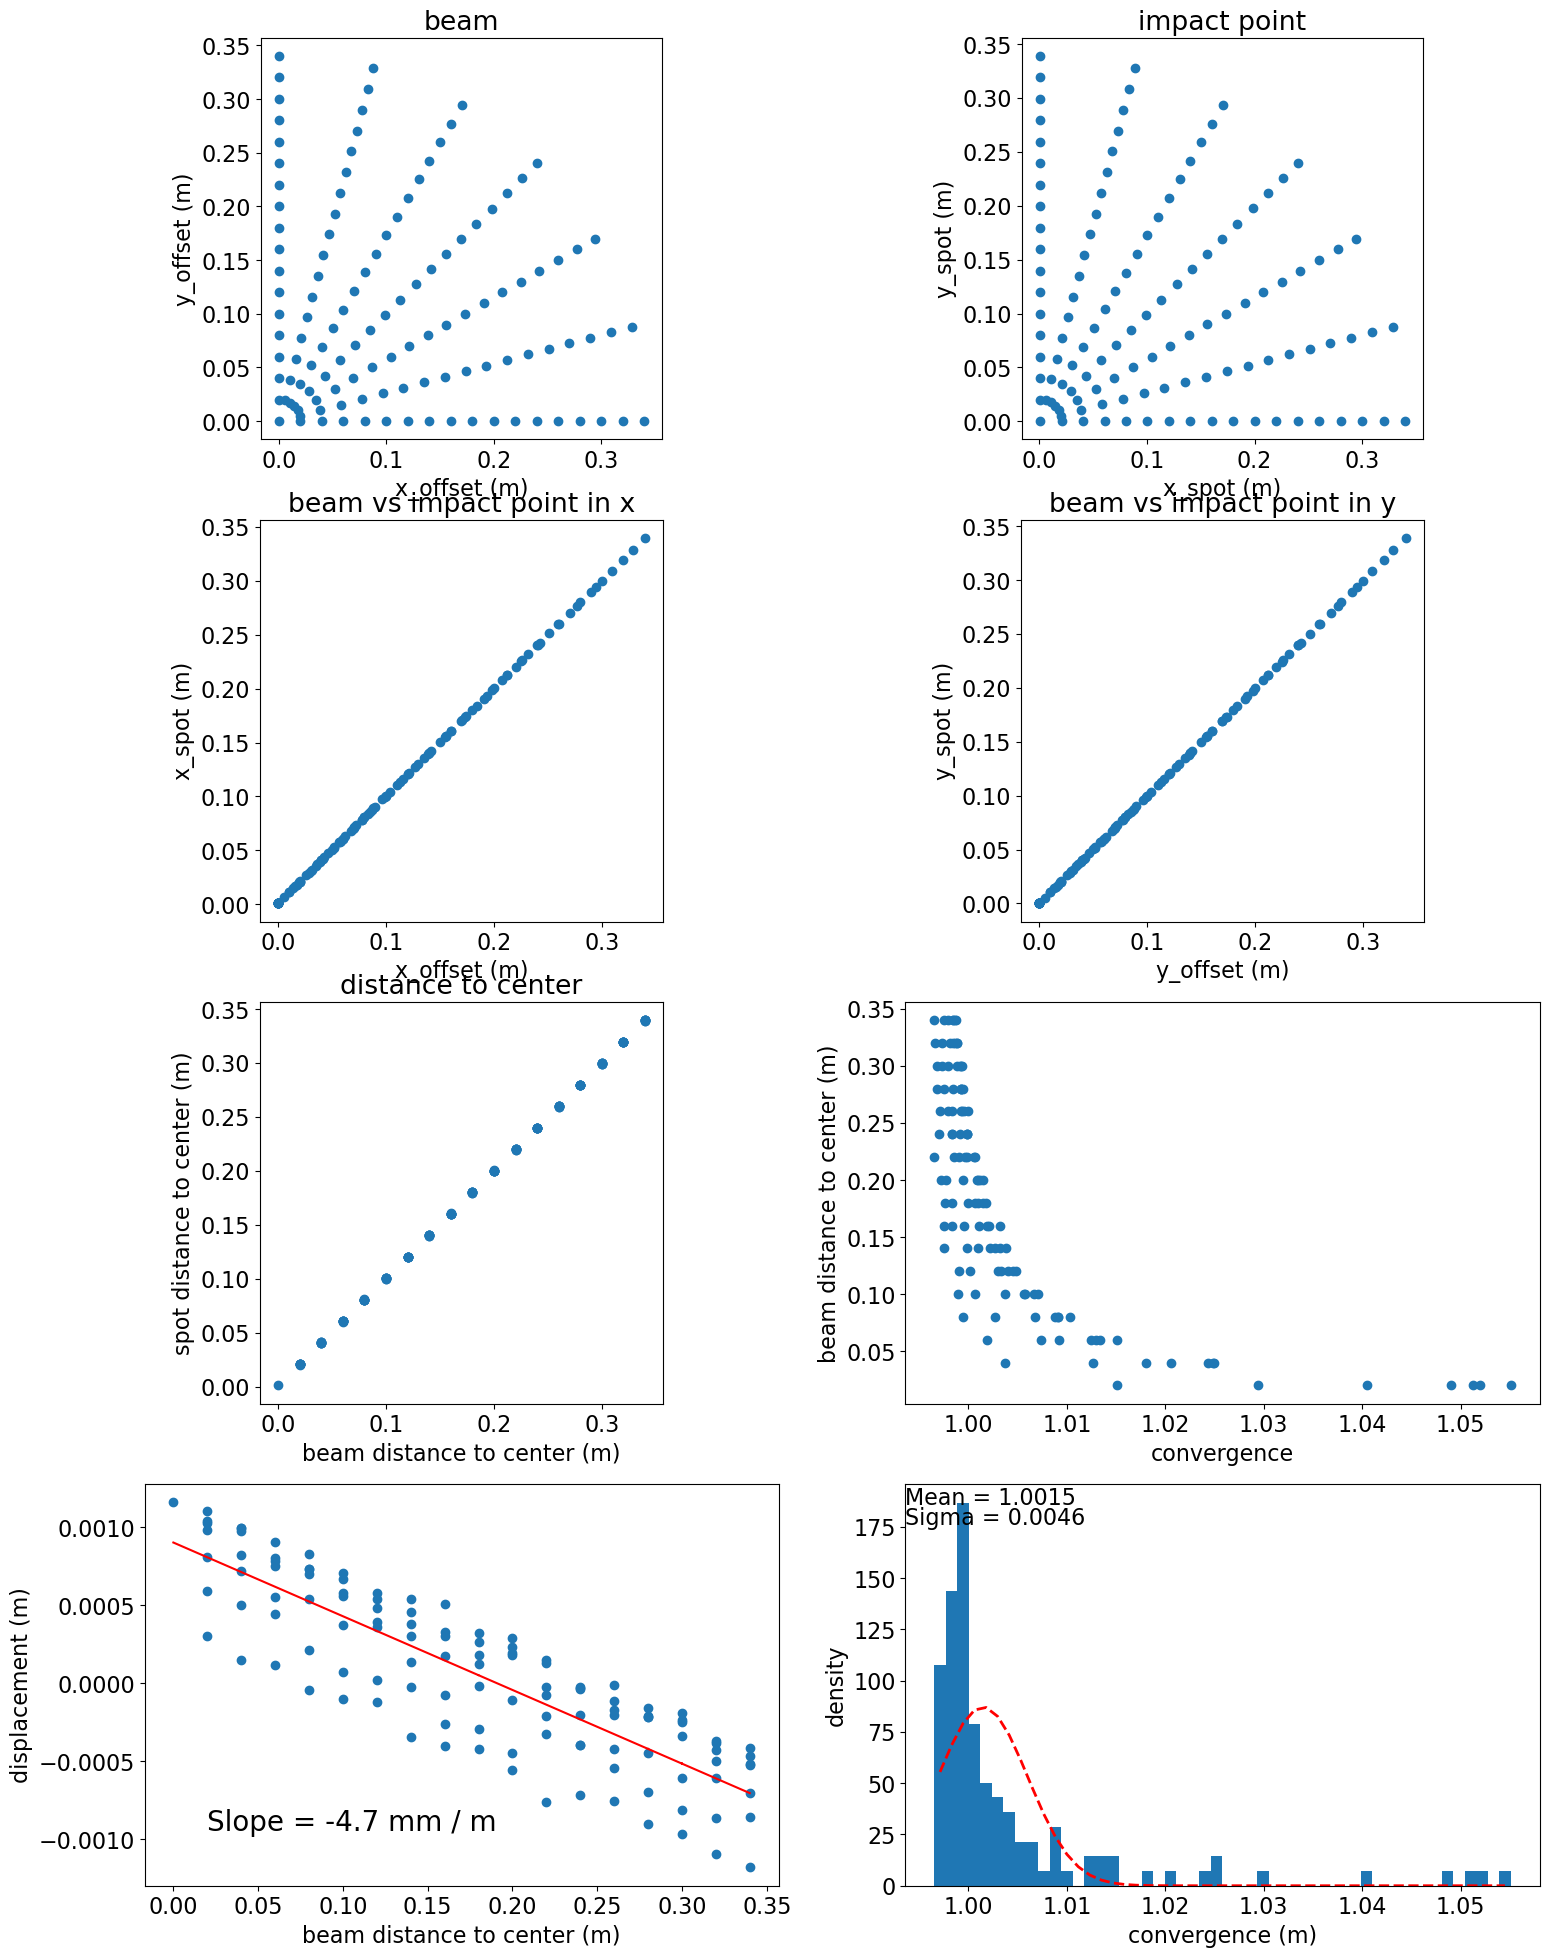

In [31]:
# plot displacement
plotter.plot_impact_point_vs_beam_offset(full_df)

## Now testing pointing the beam to a target on the camera plane given a beam position

x_euler = -1.28 y_euler = 8.92
Direct path is number 28
  central impact point is (0.003733, 0.086637)
  transmission is 0.7231

Maximum expected flux is 0.7231
Maximum bin content is 569.1179


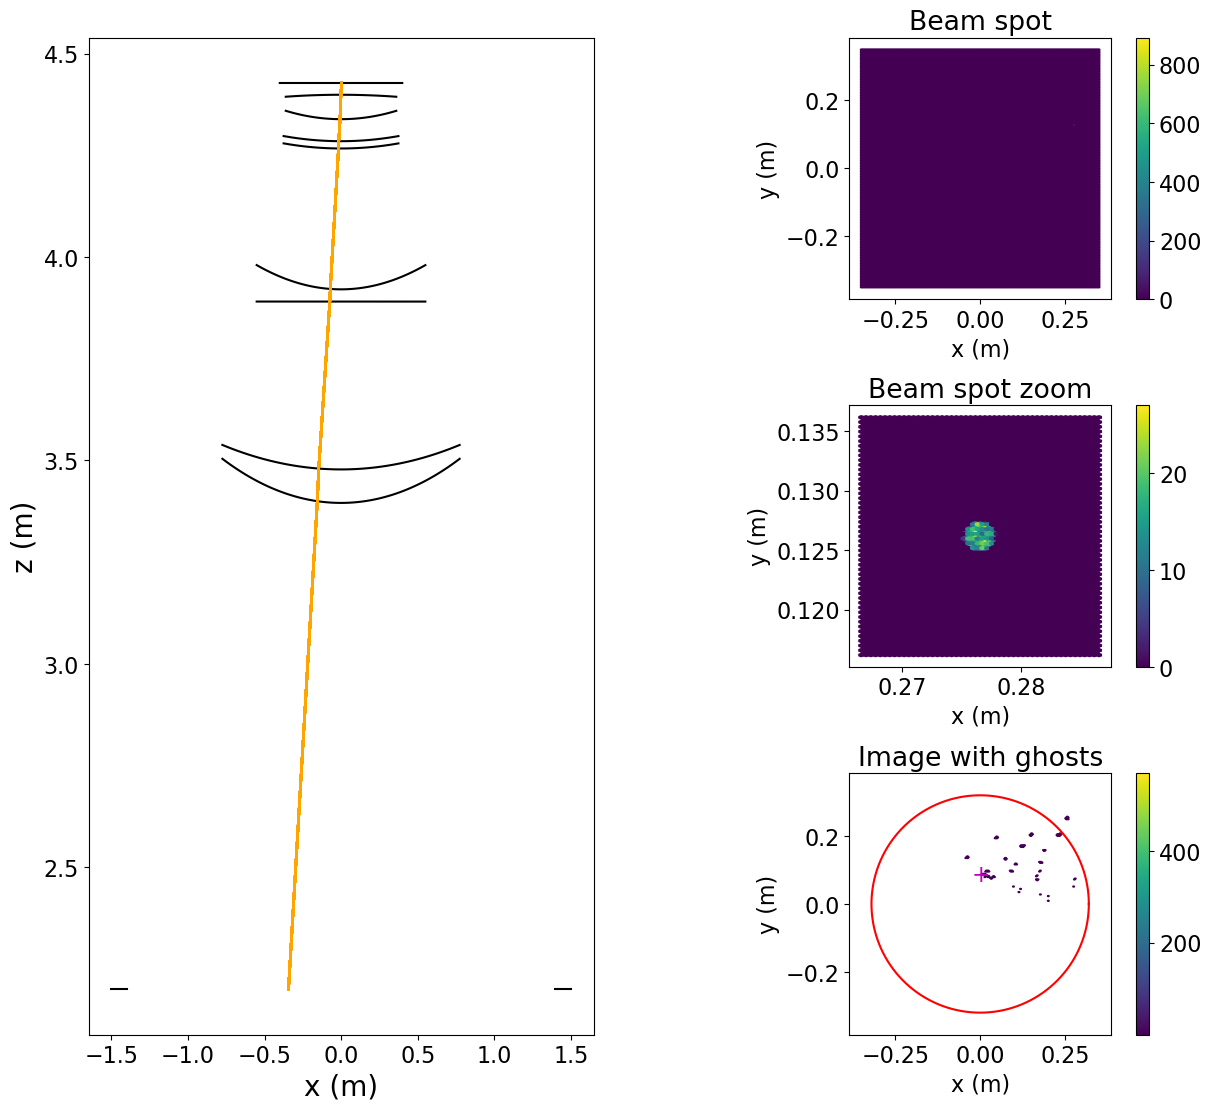

0

In [32]:
# pointing at (0.1, 0.1) from a beam at (-0.25, 0.05)
# initial beam config
test_beam = copy.deepcopy(BEAM_CONFIG_0)
test_beam['x_offset'] = -0.25
test_beam['y_offset'] = 0.05

# new beam config to target
new_beam = beam.point_beam_to_target(test_beam, target_x=0.1, target_y=0.1)
xe = new_beam['x_euler']
ye = new_beam['y_euler']
print(f'x_euler = {xe:.2f} y_euler = {ye:.2f}')

# run simulation
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=new_beam)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup and look at impact point position
plotter.plot_setup(telescope, simulation)


### Target a the beam center from a set of polar distributed beam configurations

In [33]:
# target center
target_x = 0.
target_y = 0.
# build standard polar set
polar_set = beam.build_full_frame_polar_set(set_size='medium')
polar_set_to_center = list()
# point each beam config to the camera center
for bc in polar_set:
    bt = beam.point_beam_to_target(bc, target_x, target_y)
    polar_set_to_center.append(bt)

# quick look
polar_df = beam.concat_dicts(polar_set_to_center)
polar_df.head()

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler,base_id
0,0,5.000000e-07,100,0.00125,0.000000e+00,0.000000,2.797473,0.0,-0.000000e+00,0.000000,0
1,1,5.000000e-07,100,0.00125,4.000000e-02,0.000000,2.797473,0.0,-1.027882e+00,0.000000,0
2,2,5.000000e-07,100,0.00125,3.464102e-02,0.020000,2.797473,0.0,-8.901960e-01,0.513982,0
3,3,5.000000e-07,100,0.00125,2.000000e-02,0.034641,2.797473,0.0,-5.139825e-01,0.890196,0
4,4,5.000000e-07,100,0.00125,2.449294e-18,0.040000,2.797473,0.0,-6.294639e-17,1.027882,0


In [34]:
# run simulation
full_df = simulator.simulate_impact_points_for_beam_set(telescope, polar_set_to_center)

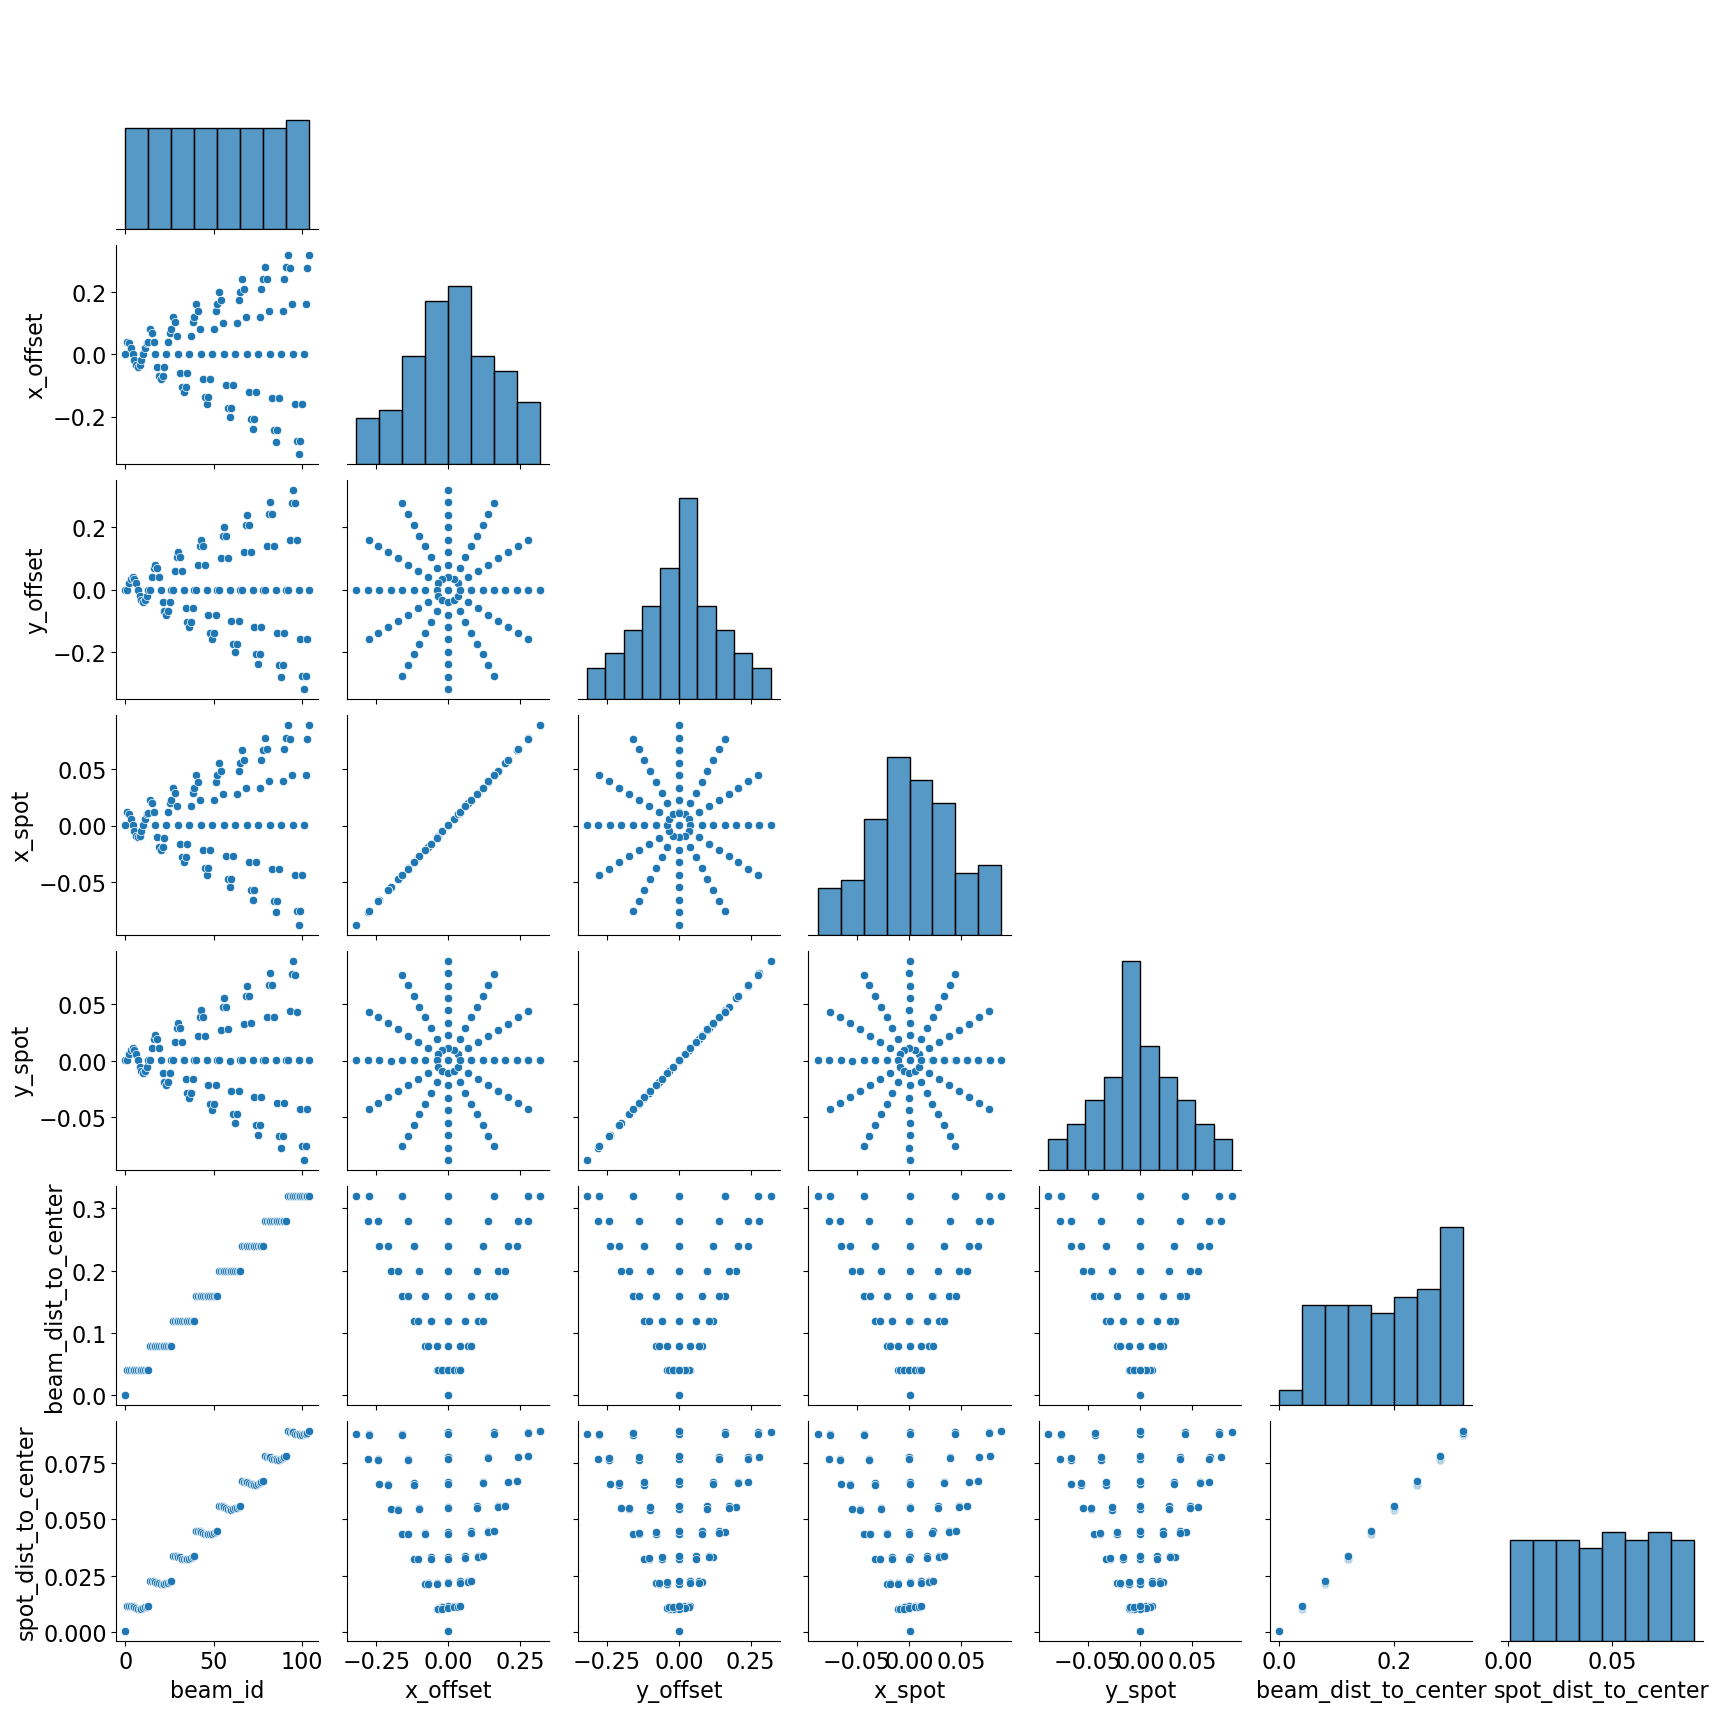

In [35]:
# pair plot to have global look at correlation between position, offset and distance to center
sns.pairplot(full_df, vars=['beam_id', 'x_offset', 'y_offset', 'x_spot', 'y_spot', 'beam_dist_to_center', 'spot_dist_to_center'], corner=True)

The pointing precision at order 0 is of the order of ~1 mm


(<Figure size 1800x900 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Difference between target and real impact point (x)'}, xlabel='delta x (mm)', ylabel='n spots'>,
        <AxesSubplot:title={'center':'Difference between target and real impact point (y)'}, xlabel='delta y (mm)', ylabel='n spots'>],
       dtype=object))

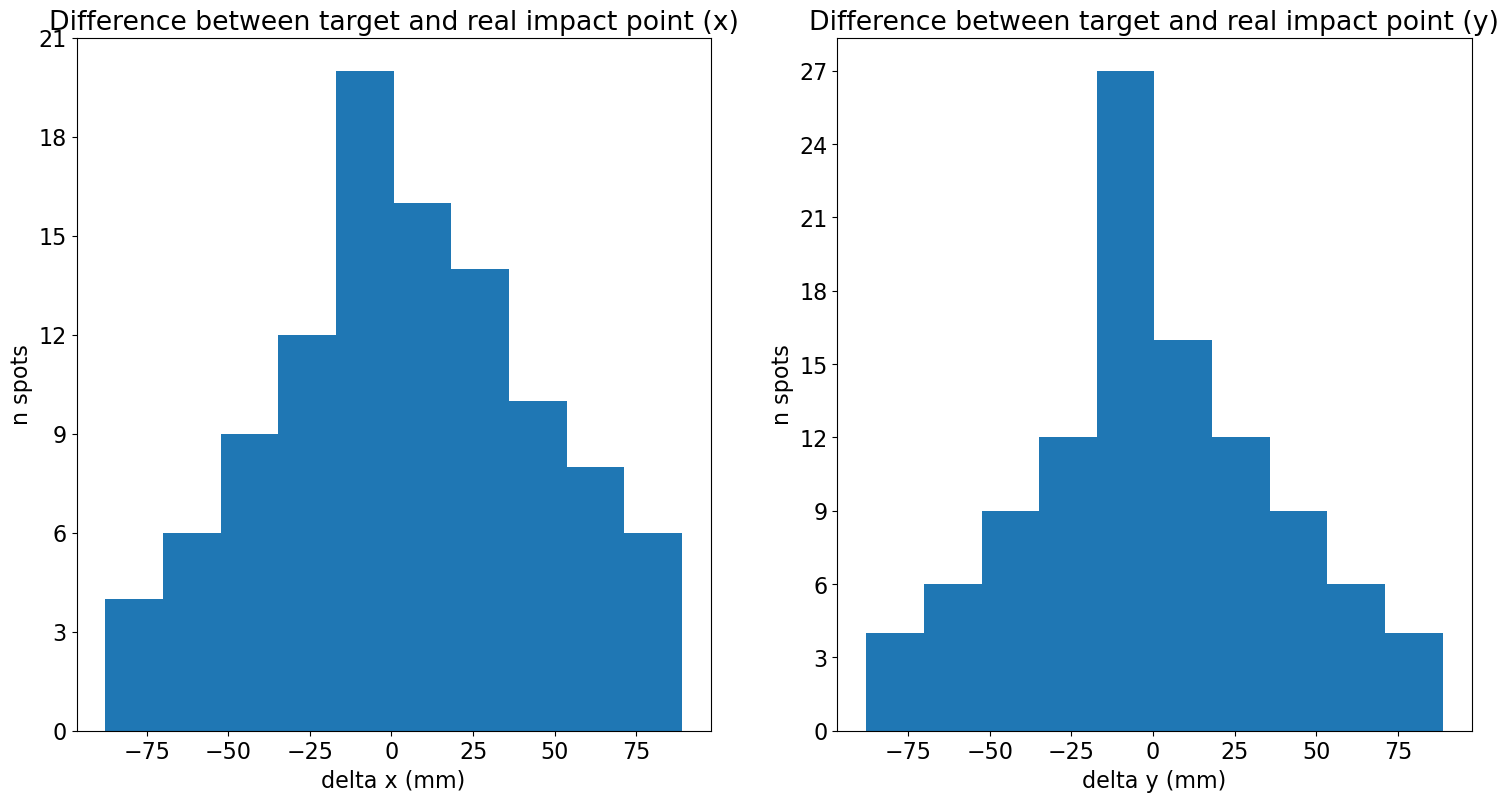

In [36]:
plotter.plot_beam_pointing_precision(full_df, target_x, target_y)

### Now show how to make a square beam set around a given target from a fixed beam position

In [37]:
# reference configuration
ref_config = copy.deepcopy(BEAM_CONFIG_1)
# (0.1, 0.1) is our target
ref_config['x_offset'] = 0.1
ref_config['y_offset'] = 0.1
ref_config['n_photons'] = 100

# small sampling for our square
dist_sampling = np.arange(-0.05, 0.05, 0.02)
# build configurations, only pointing at the beam, not moving it
beam_patch = beam.build_square_set_on_target(ref_config, dist_sampling,
                                             target_x=-0.1, target_y=-0.05, base_id=12)
patch_df = beam.concat_dicts(beam_patch)
patch_df.head()

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler
12,12,5.000000e-07,100,0.00125,0.1,0.1,2.797473,0.0,-6.398224,5.126240
13,13,5.000000e-07,100,0.00125,0.1,0.1,2.797473,0.0,-6.398224,4.615954
14,14,5.000000e-07,100,0.00125,0.1,0.1,2.797473,0.0,-6.398224,4.104932
15,15,5.000000e-07,100,0.00125,0.1,0.1,2.797473,0.0,-6.398224,3.593256
16,16,5.000000e-07,100,0.00125,0.1,0.1,2.797473,0.0,-6.398224,3.081004


In [38]:
patch_full_df = simulator.simulate_impact_points_for_beam_set(telescope, beam_patch)


0

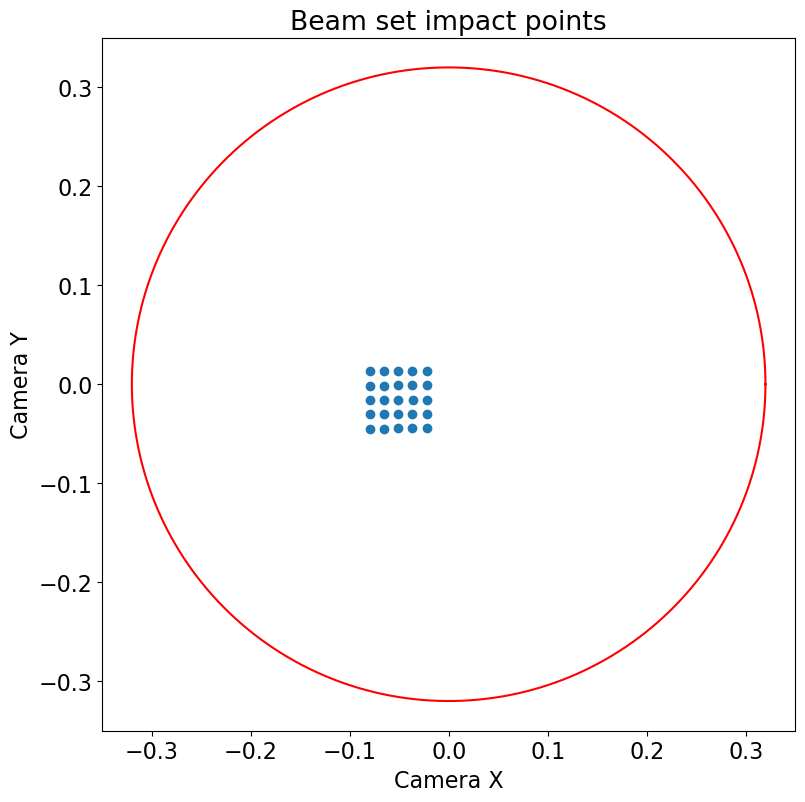

In [39]:
plotter.plot_impact_points_full_frame(patch_full_df)

### Show how to build a full frame square set

In [40]:
full_square_grid = beam.build_full_frame_square_set(delta=0.05, d_max=0.2)
sq_df = beam.concat_dicts(full_square_grid)
sq_df.head()

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler
0,0,5.000000e-07,100,0.00125,-0.2,-2.000000e-01,2.797473,0.0,0.0,0.0
1,1,5.000000e-07,100,0.00125,-0.2,-1.500000e-01,2.797473,0.0,0.0,0.0
2,2,5.000000e-07,100,0.00125,-0.2,-1.000000e-01,2.797473,0.0,0.0,0.0
3,3,5.000000e-07,100,0.00125,-0.2,-5.000000e-02,2.797473,0.0,0.0,0.0
4,4,5.000000e-07,100,0.00125,-0.2,-5.551115e-17,2.797473,0.0,0.0,0.0


In [41]:
square_grid_df = simulator.simulate_impact_points_for_beam_set(telescope, full_square_grid)

<AxesSubplot:title={'center':'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

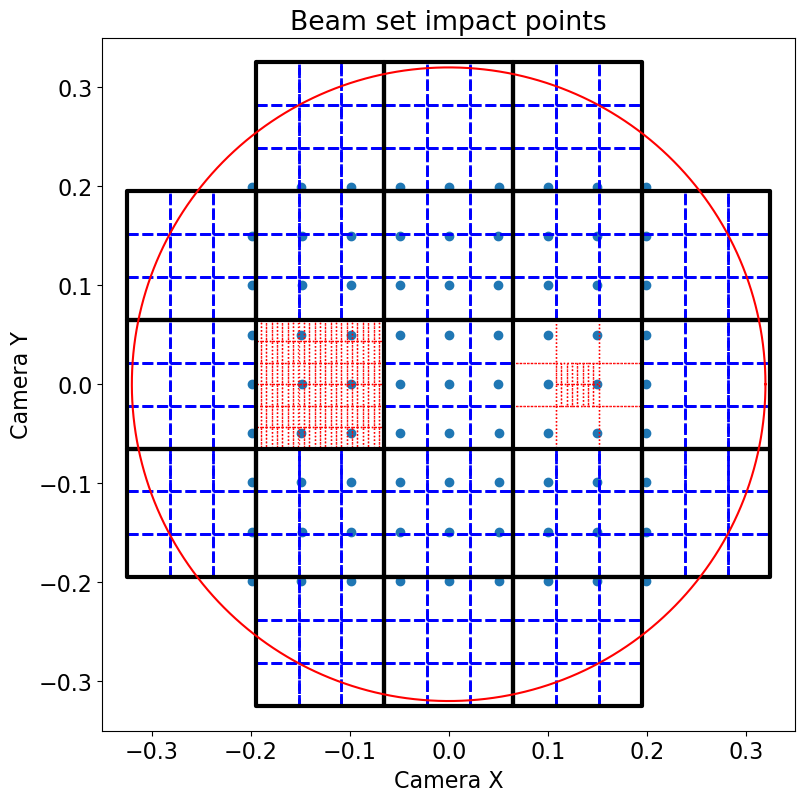

In [42]:
plotter.plot_impact_points_full_frame(square_grid_df)
camera = build_camera()
show_camera(plt.gca(), camera)


In [43]:
sq_df.head()

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler
0,0,5.000000e-07,100,0.00125,-0.2,-2.000000e-01,2.797473,0.0,0.0,0.0
1,1,5.000000e-07,100,0.00125,-0.2,-1.500000e-01,2.797473,0.0,0.0,0.0
2,2,5.000000e-07,100,0.00125,-0.2,-1.000000e-01,2.797473,0.0,0.0,0.0
3,3,5.000000e-07,100,0.00125,-0.2,-5.000000e-02,2.797473,0.0,0.0,0.0
4,4,5.000000e-07,100,0.00125,-0.2,-5.551115e-17,2.797473,0.0,0.0,0.0
